# Experimentación - STConv


https://arxiv.org/abs/1709.04875

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
results_save_path = "./results"
name_model = "STConv"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados



from utils.trainer import TrainerSTConv
from  utils.stgcn import STConv
#from torch_geometric_temporal.nn import TGCN

In [7]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, out_channels,k, kernel_size, hidden_channels, normalization="sym"):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        self.out_channels = out_channels
        self.k = k
        self.kernel_size = kernel_size
        self.normalization = normalization
        self.hidden_channels = hidden_channels
        super(RecurrentGCN, self).__init__()
        self.recurrent = STConv(num_nodes=node_count,
                                in_channels=1,
                                hidden_channels=hidden_channels,
                                out_channels=out_channels,
                                kernel_size=kernel_size,
                                K=k,  # Grado del polinomio Chebyshev
                                normalization=normalization 
                            )

        self.linear = torch.nn.Linear(self.out_channels, self.n_target)


    def forward(self, x, edge_index, edge_weight):

        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = h.squeeze(0).mean(dim=0)
        h = self.linear(h)
        return h


In [18]:
import itertools


def entrenar_y_evaluar_modelos_stconv(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    
    resultados_list = []

    n_div_bt = loader.div
    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None
    
    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for out_channels, kernel_size, hidden_channels, normalization in tqdm(list(itertools.product(param_grid["out_channels"], param_grid['kernel_size'],param_grid['hidden_channels'], param_grid['normalization']))):
        model_bt = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=out_channels,k=2, kernel_size=kernel_size, hidden_channels=hidden_channels, normalization=normalization)

        trainer_bt = TrainerSTConv(model_bt, dataset,device, f"./results/{problem}", dataloader_params)



        losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer_bt.test()
    
        results_intermedio = {
            "Out channels": out_channels,
            "Kernel size": kernel_size,
            "Hidden channels": hidden_channels,
            "Normalization": normalization,
            "loss_final": losses[-1],
            "r2_eval_final": np.mean(r2scores[-1]),
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst),
            "loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer_bt
            mejores_parametros = {"Out channels": out_channels, "Kernel size": kernel_size, "Hidden channels": hidden_channels, "Normalization": normalization}
            mejores_resultados = results_intermedio

        print("Resultados intermedios: ", results_intermedio)

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_gt


## Prueba - predicción por tipos

In [8]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [9]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [10]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =100

In [11]:
from utils.trainer import train_test_val_split

In [12]:
loader_dt = train_test_val_split(dataset_gt, batch_size=dataloader_params2["batch_size"],
                                                   data_split_ratio=dataloader_params2["data_split_ratio"],
                                                   random_seed=dataloader_params2["seed"],
                                                   keep_same=dataloader_params2["keep_same"],
                                                   use_batch=dataloader_params2["use_batch"])




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942


#### Sencilla 

In [13]:


device = torch.device("cpu")
model_gt = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=30,k=2, kernel_size=5, hidden_channels=16, normalization="sym")

trainer_gt = TrainerSTConv(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.8059 | Eval Loss: 0.4936 | Eval R2: -232.0262 | 
Epoch 2/30 | Train Loss: 0.3616 | Eval Loss: 0.2411 | Eval R2: -104.5822 | 
Epoch 3/30 | Train Loss: 0.1895 | Eval Loss: 0.1208 | Eval R2: -45.9687 | 
Epoch 4/30 | Train Loss: 0.1183 | Eval Loss: 0.0743 | Eval R2: -23.8989 | 
Epoch 5/30 | Train Loss: 0.0871 | Eval Loss: 0.0600 | Eval R2: -18.2273 | 
Epoch 6/30 | Train Loss: 0.0684 | Eval Loss: 0.0494 | Eval R2: -15.5463 | 
Epoch 7/30 | Train Loss: 0.0582 | Eval Loss: 0.0462 | Eval R2: -15.5731 | 
Epoch 8/30 | Train Loss: 0.0530 | Eval Loss: 0.0453 | Eval R2: -16.0338 | 
Epoch 9/30 | Train Loss: 0.0499 | Eval Loss: 0.0449 | Eval R2: -16.1380 | 
Epoch 10/30 | Train Loss: 0.0477 | Eval Loss: 0.0447 | Eval R2: -16.2356 | 
Epoch 11/30 | Train Loss: 0.0463 | Eval Loss: 0.0448 | Eval R2: -16.5370 | 

KeyboardInterrupt: 

In [17]:
losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=10, steps=1000, num_early_stop=num_early_stop)


==================== TRAIN INFO ===================

Epoch 1/10 | Train Loss: 0.0719 | Eval Loss: 0.1141 | Eval R2: -49.3303 | 
Epoch 2/10 | Train Loss: 0.0417 | Eval Loss: 0.0764 | Eval R2: -30.3946 | 
Epoch 3/10 | Train Loss: 0.0397 | Eval Loss: 0.0723 | Eval R2: -28.2929 | 
Epoch 4/10 | Train Loss: 0.0350 | Eval Loss: 0.0730 | Eval R2: -29.0207 | 
Epoch 5/10 | Train Loss: 0.0316 | Eval Loss: 0.0673 | Eval R2: -25.1501 | 
Epoch 6/10 | Train Loss: 0.0324 | Eval Loss: 0.0663 | Eval R2: -24.8484 | 
Epoch 7/10 | Train Loss: 0.0298 | Eval Loss: 0.0678 | Eval R2: -26.0490 | 
Epoch 8/10 | Train Loss: 0.0295 | Eval Loss: 0.0630 | Eval R2: -23.4157 | 
Epoch 9/10 | Train Loss: 0.0290 | Eval Loss: 0.0602 | Eval R2: -22.1183 | 
Epoch 10/10 | Train Loss: 0.0279 | Eval Loss: 0.0591 | Eval R2: -21.7068 | 


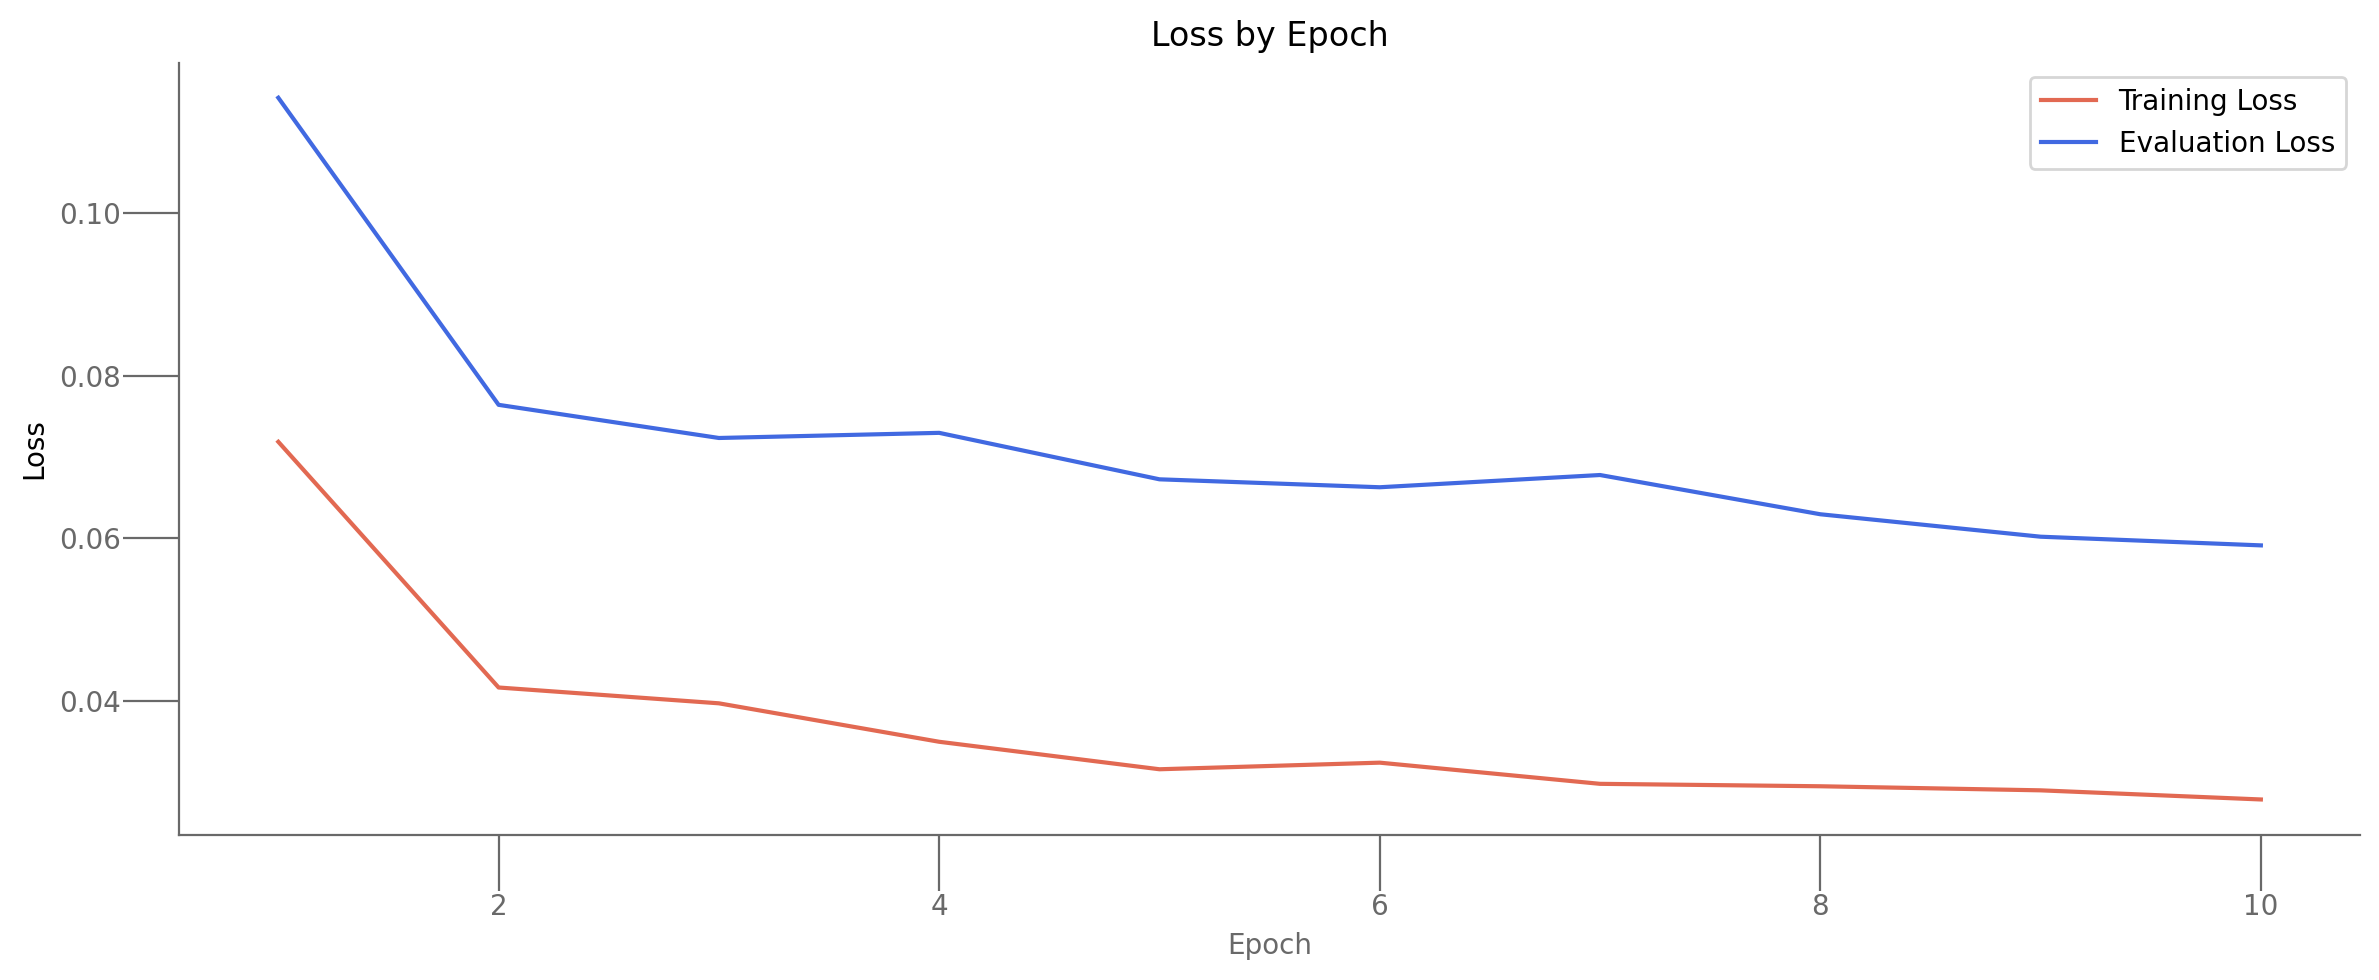


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.048961, test r2score -21.498783


In [20]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), 10, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()


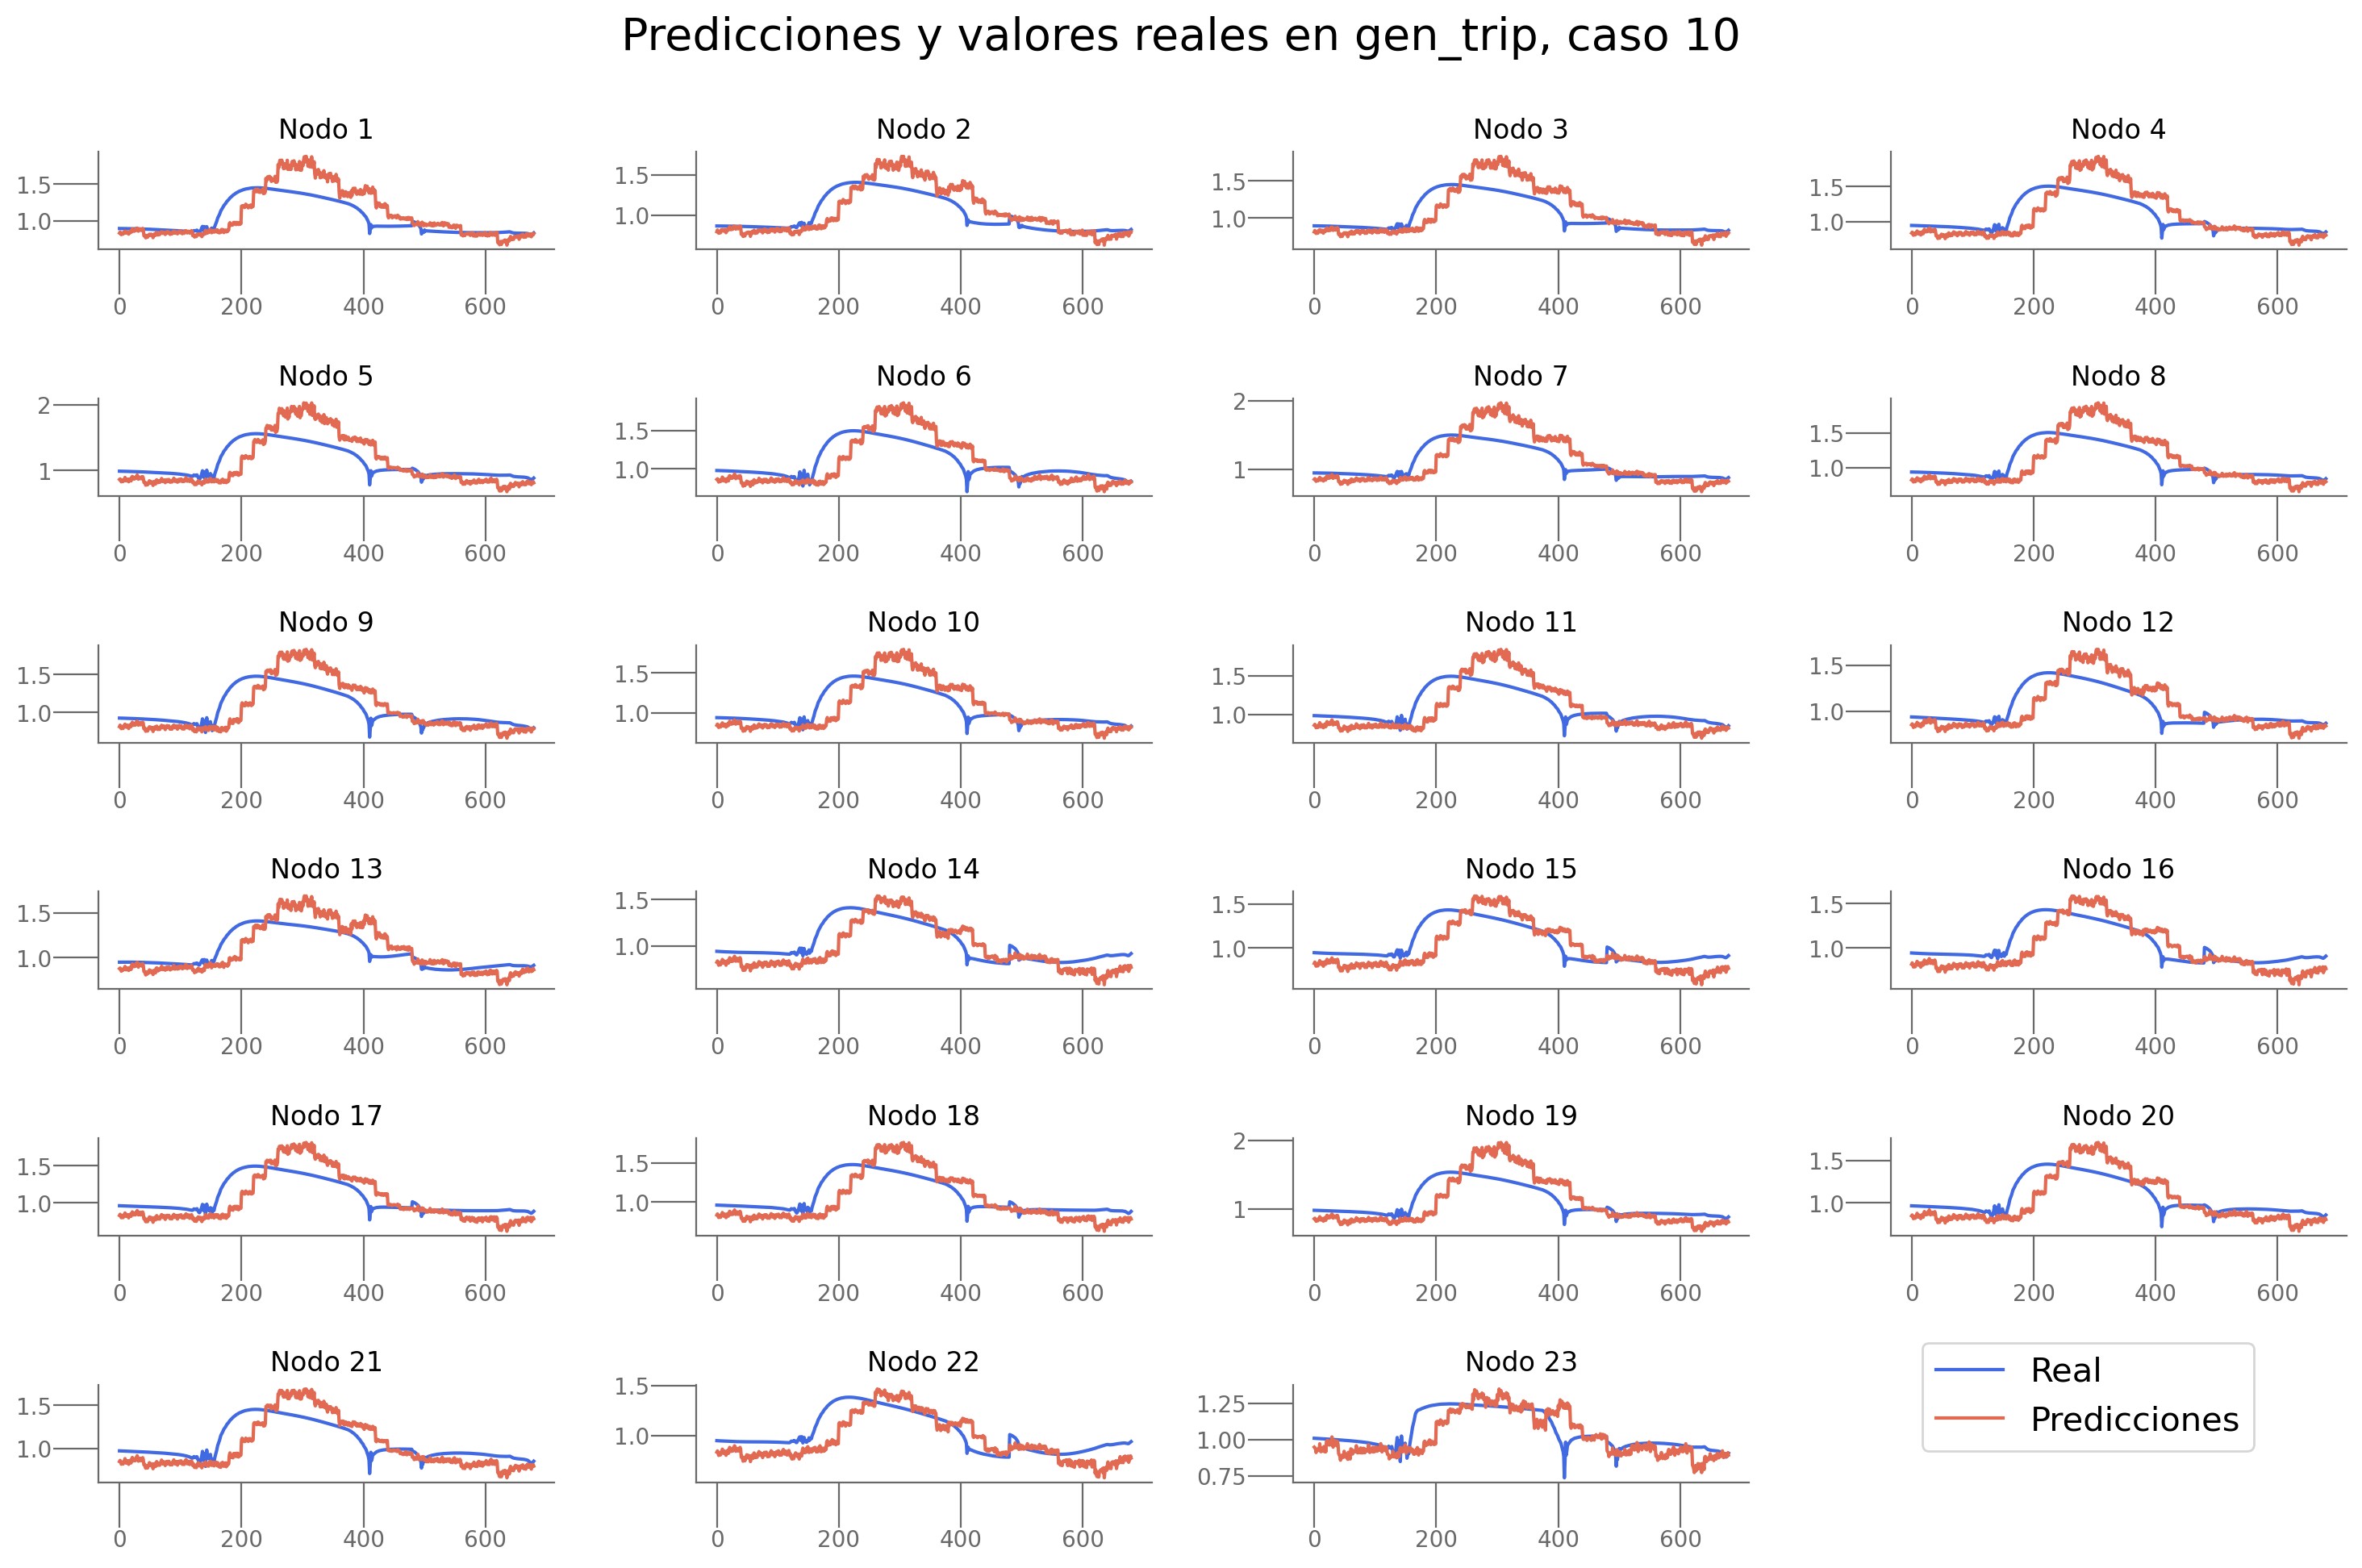

In [24]:
plot_predictions(predictions_gt, real_gt, n_target, 10, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [115]:
param_grid = {
    "out_channels": [16, 32, 64],
    "kernel_size": [3,5,7],
    "normalization": ["sym", "rw"],
    "hidden_channels": [16, 32, 64],
}



trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_stconv(param_grid, dataset_gt, dataloader_params2, num_early_stop, num_epochs, problem=problem_gt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1346 | Eval Loss: 0.2437 | Eval R2: -123.8613 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2432 | Eval Loss: 0.4000 | Eval R2: -231.6969 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.3933 | Eval Loss: 0.5348 | Eval R2: -306.2963 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.5242 | Eval Loss: 0.4205 | Eval R2: -234.5579 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.4131 | Eval Loss: 0.3936 | Eval R2: -218.7589 | LR: 0.001000
Epoch 6/30 | Train Loss: 0.3870 | Eval Loss: 0.3537 | Eval R2: -195.7232 | LR: 0.001000
Epoch 7/30 | Train Loss: 0.3481 | Eval Loss: 0.3075 | Eval R2: -169.2290 | LR: 0.001000
Epoch 8/30 | Train Loss: 0.3032 | Eval Loss: 0.2600 | Eval R2: -141.9396 | LR: 0.001000
Epoch 9/30 | Train Loss: 0.2569 | Eval Loss: 0.2144 | Eval R2: -115.7483 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.2125 | Eval Loss: 0.1732 | Eval R2: -91.9724 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.1725 | Eval Loss: 0.1379 | Eval R2: -7

 11%|█         | 1/9 [44:19<5:54:36, 2659.54s/it]

Test_loss:0.0459, Test_r2:-18.2476
Parámetros:  16 0.2
Resultados:  {'Hidden Size': 16, 'Dropout': 0.2, 'loss_final': 0.059339359402656555, 'r2_eval_final': -16.74396383319979, 'loss_eval_final': 0.05281999944383779, 'r2_test': -18.247557962578973, 'loss_test': 0.045888711324390694, 'loss_nodes': [0.04005108401179314, 0.03960233926773071, 0.04245578497648239, 0.05000418797135353, 0.05457543954253197, 0.05410129576921463, 0.04520959034562111, 0.050709161907434464, 0.053248900920152664, 0.04801873117685318, 0.05347105860710144, 0.04706619307398796, 0.0329555980861187, 0.04058605059981346, 0.04236998036503792, 0.04229291155934334, 0.048861924558877945, 0.04811285063624382, 0.0527091920375824, 0.04839203506708145, 0.04876969754695892, 0.03715735301375389, 0.034719016402959824]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.3311 | Eval Loss: 0.3376 | Eval R2: -167.2742 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.3353 | Eval Loss: 0.3535 | Eval R2: -201.8154 

 22%|██▏       | 2/9 [1:28:47<5:10:49, 2664.27s/it]

Parámetros:  16 0.5
Resultados:  {'Hidden Size': 16, 'Dropout': 0.5, 'loss_final': 0.06413242965936661, 'r2_eval_final': -19.268094334912664, 'loss_eval_final': 0.05962369839200169, 'r2_test': -21.074888177538668, 'loss_test': 0.05222091164747392, 'loss_nodes': [0.04612398147583008, 0.045635886490345, 0.04870729148387909, 0.05668950825929642, 0.06151047721505165, 0.06095130741596222, 0.05161602422595024, 0.05745740979909897, 0.06016351282596588, 0.0545123815536499, 0.0602375790476799, 0.05315402150154114, 0.03855343535542488, 0.046596892178058624, 0.0485057458281517, 0.04841861128807068, 0.055431291460990906, 0.05460915341973305, 0.05951899290084839, 0.05486736446619034, 0.05521240830421448, 0.042913008481264114, 0.03969471901655197]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.4442 | Eval Loss: 0.2587 | Eval R2: -128.4083 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2592 | Eval Loss: 0.3701 | Eval R2: -214.2966 | LR: 0.010000
Epoch 3/30 | Train Loss: 

 33%|███▎      | 3/9 [2:12:52<4:25:34, 2655.74s/it]

Parámetros:  16 0.8
Resultados:  {'Hidden Size': 16, 'Dropout': 0.8, 'loss_final': 0.07151132076978683, 'r2_eval_final': -22.933142975979294, 'loss_eval_final': 0.06706408320285219, 'r2_test': -25.639788744422503, 'loss_test': 0.05968188459099114, 'loss_nodes': [0.052659984678030014, 0.05214943736791611, 0.05554809793829918, 0.06437511742115021, 0.06982345879077911, 0.0688423439860344, 0.05916539579629898, 0.06512244045734406, 0.06767886132001877, 0.06190342456102371, 0.06814389675855637, 0.06052844598889351, 0.045558176934719086, 0.053939465433359146, 0.05595899373292923, 0.05586447939276695, 0.06325540691614151, 0.06235359236598015, 0.06766817718744278, 0.06251651048660278, 0.06286345422267914, 0.050105493515729904, 0.04665864631533623]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1745 | Eval Loss: 0.1672 | Eval R2: -84.3774 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.1676 | Eval Loss: 0.4430 | Eval R2: -258.5022 | LR: 0.010000
Epoch 3/30 | Train Lo

 44%|████▍     | 4/9 [2:55:07<3:37:20, 2608.15s/it]

Parámetros:  32 0.2
Resultados:  {'Hidden Size': 32, 'Dropout': 0.2, 'loss_final': 0.06089671701192856, 'r2_eval_final': -19.28983257662289, 'loss_eval_final': 0.05599029939721829, 'r2_test': -21.083466331870103, 'loss_test': 0.04880351948550845, 'loss_nodes': [0.04323829710483551, 0.04277472943067551, 0.04561297968029976, 0.053183093667030334, 0.057898156344890594, 0.05701735243201256, 0.04819950833916664, 0.053868722170591354, 0.05628072842955589, 0.050850752741098404, 0.05636042356491089, 0.04976102337241173, 0.03499096259474754, 0.04355679079890251, 0.04539499804377556, 0.045297667384147644, 0.052014973014593124, 0.05115482956171036, 0.05595260486006737, 0.05122232809662819, 0.05149070546030998, 0.040013257414102554, 0.03634600713849068]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1797 | Eval Loss: 0.1977 | Eval R2: -99.8852 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.1970 | Eval Loss: 0.3789 | Eval R2: -220.2562 | LR: 0.010000
Epoch 3/30 | Train

 56%|█████▌    | 5/9 [3:36:56<2:51:28, 2572.19s/it]

Parámetros:  32 0.5
Resultados:  {'Hidden Size': 32, 'Dropout': 0.5, 'loss_final': 0.06460060179233551, 'r2_eval_final': -19.857736440667725, 'loss_eval_final': 0.059803479631000786, 'r2_test': -22.033685408506802, 'loss_test': 0.05247809132066755, 'loss_nodes': [0.04538840427994728, 0.04492497816681862, 0.048178836703300476, 0.056673601269721985, 0.062038227915763855, 0.06093430519104004, 0.052089300006628036, 0.05731464922428131, 0.059462450444698334, 0.054364755749702454, 0.06035974994301796, 0.05335164815187454, 0.040101058781147, 0.04727226123213768, 0.0491219237446785, 0.049035076051950455, 0.05583139508962631, 0.054995182901620865, 0.06000453978776932, 0.055122558027505875, 0.055493537336587906, 0.04384059086441994, 0.04109695181250572]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.4422 | Eval Loss: 0.2819 | Eval R2: -141.7655 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2809 | Eval Loss: 0.3535 | Eval R2: -204.7206 | LR: 0.010000
Epoch 3/30 | Tr

 67%|██████▋   | 6/9 [4:22:24<2:11:15, 2625.11s/it]

Parámetros:  32 0.8
Resultados:  {'Hidden Size': 32, 'Dropout': 0.8, 'loss_final': 0.06867166608572006, 'r2_eval_final': -21.38727758941312, 'loss_eval_final': 0.06493362657655712, 'r2_test': -23.730658056989217, 'loss_test': 0.05742384277624246, 'loss_nodes': [0.050971806049346924, 0.050453200936317444, 0.05372653529047966, 0.06214169040322304, 0.06742522120475769, 0.06624498963356018, 0.05712514370679855, 0.06288108229637146, 0.06525149941444397, 0.05960780382156372, 0.06555551290512085, 0.058081842958927155, 0.043594054877758026, 0.05175933614373207, 0.0537605956196785, 0.053658172488212585, 0.06095137447118759, 0.0600123256444931, 0.06528592109680176, 0.060064516961574554, 0.06033720448613167, 0.04794891178607941, 0.04390982538461685]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.5466 | Eval Loss: 0.2580 | Eval R2: -125.1556 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2564 | Eval Loss: 0.3685 | Eval R2: -214.9168 | LR: 0.010000
Epoch 3/30 | Train L

 78%|███████▊  | 7/9 [5:04:55<1:26:41, 2600.90s/it]

Parámetros:  64 0.2
Resultados:  {'Hidden Size': 64, 'Dropout': 0.2, 'loss_final': 0.07134269177913666, 'r2_eval_final': -22.878516178369914, 'loss_eval_final': 0.06728489242984803, 'r2_test': -25.699249139095198, 'loss_test': 0.05995481872076916, 'loss_nodes': [0.05259605124592781, 0.052092183381319046, 0.05553440377116203, 0.06451107561588287, 0.0701817199587822, 0.06895554810762405, 0.05958837643265724, 0.06519844383001328, 0.06747262924909592, 0.06199856474995613, 0.06833157688379288, 0.060766302049160004, 0.04662474989891052, 0.054391346871852875, 0.056371044367551804, 0.056274283677339554, 0.06355344504117966, 0.06264165043830872, 0.0680060014128685, 0.06274238973855972, 0.06309816241264343, 0.05070927366614342, 0.04732184857130051]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.2170 | Eval Loss: 0.1593 | Eval R2: -76.7107 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.1618 | Eval Loss: 0.4310 | Eval R2: -251.6436 | LR: 0.010000
Epoch 3/30 | Train Lo

 89%|████████▉ | 8/9 [5:47:17<43:02, 2582.34s/it]  

Parámetros:  64 0.5
Resultados:  {'Hidden Size': 64, 'Dropout': 0.5, 'loss_final': 0.06585948914289474, 'r2_eval_final': -20.02512590350287, 'loss_eval_final': 0.06051149735182163, 'r2_test': -22.161282759413027, 'loss_test': 0.053539144713135, 'loss_nodes': [0.04790707305073738, 0.047420237213373184, 0.05039568990468979, 0.0581217035651207, 0.06294255703687668, 0.06190590187907219, 0.053188733756542206, 0.05884724110364914, 0.06121295318007469, 0.05569515377283096, 0.061217136681079865, 0.05424058437347412, 0.03983854502439499, 0.04804987087845802, 0.04996666684746742, 0.049866627901792526, 0.056852299720048904, 0.05594847351312637, 0.060925230383872986, 0.055988579988479614, 0.05622059851884842, 0.044354695826768875, 0.040293850004673004]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.3025 | Eval Loss: 0.2222 | Eval R2: -110.4768 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.2218 | Eval Loss: 0.4126 | Eval R2: -240.2957 | LR: 0.010000
Epoch 3/30 | Train

100%|██████████| 9/9 [6:29:25<00:00, 2596.17s/it]

Parámetros:  64 0.8
Resultados:  {'Hidden Size': 64, 'Dropout': 0.8, 'loss_final': 0.062192440032958984, 'r2_eval_final': -18.588000821052933, 'loss_eval_final': 0.05747282864971547, 'r2_test': -20.208539462365906, 'loss_test': 0.05035309146297799, 'loss_nodes': [0.04485355690121651, 0.044357724487781525, 0.04729725420475006, 0.054979290813207626, 0.05979626998305321, 0.05877571925520897, 0.04993659257888794, 0.055706724524497986, 0.058121323585510254, 0.05252838507294655, 0.058081939816474915, 0.051146816462278366, 0.03633420541882515, 0.04479730874300003, 0.04672406613826752, 0.04662144184112549, 0.0536670945584774, 0.05275396257638931, 0.05776413530111313, 0.052795227617025375, 0.05303472280502319, 0.04107939824461937, 0.03696782886981964]}


In [ ]:
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()



==================== TEST INFO ===================

Test_loss:0.0459, Test_r2:-18.2476


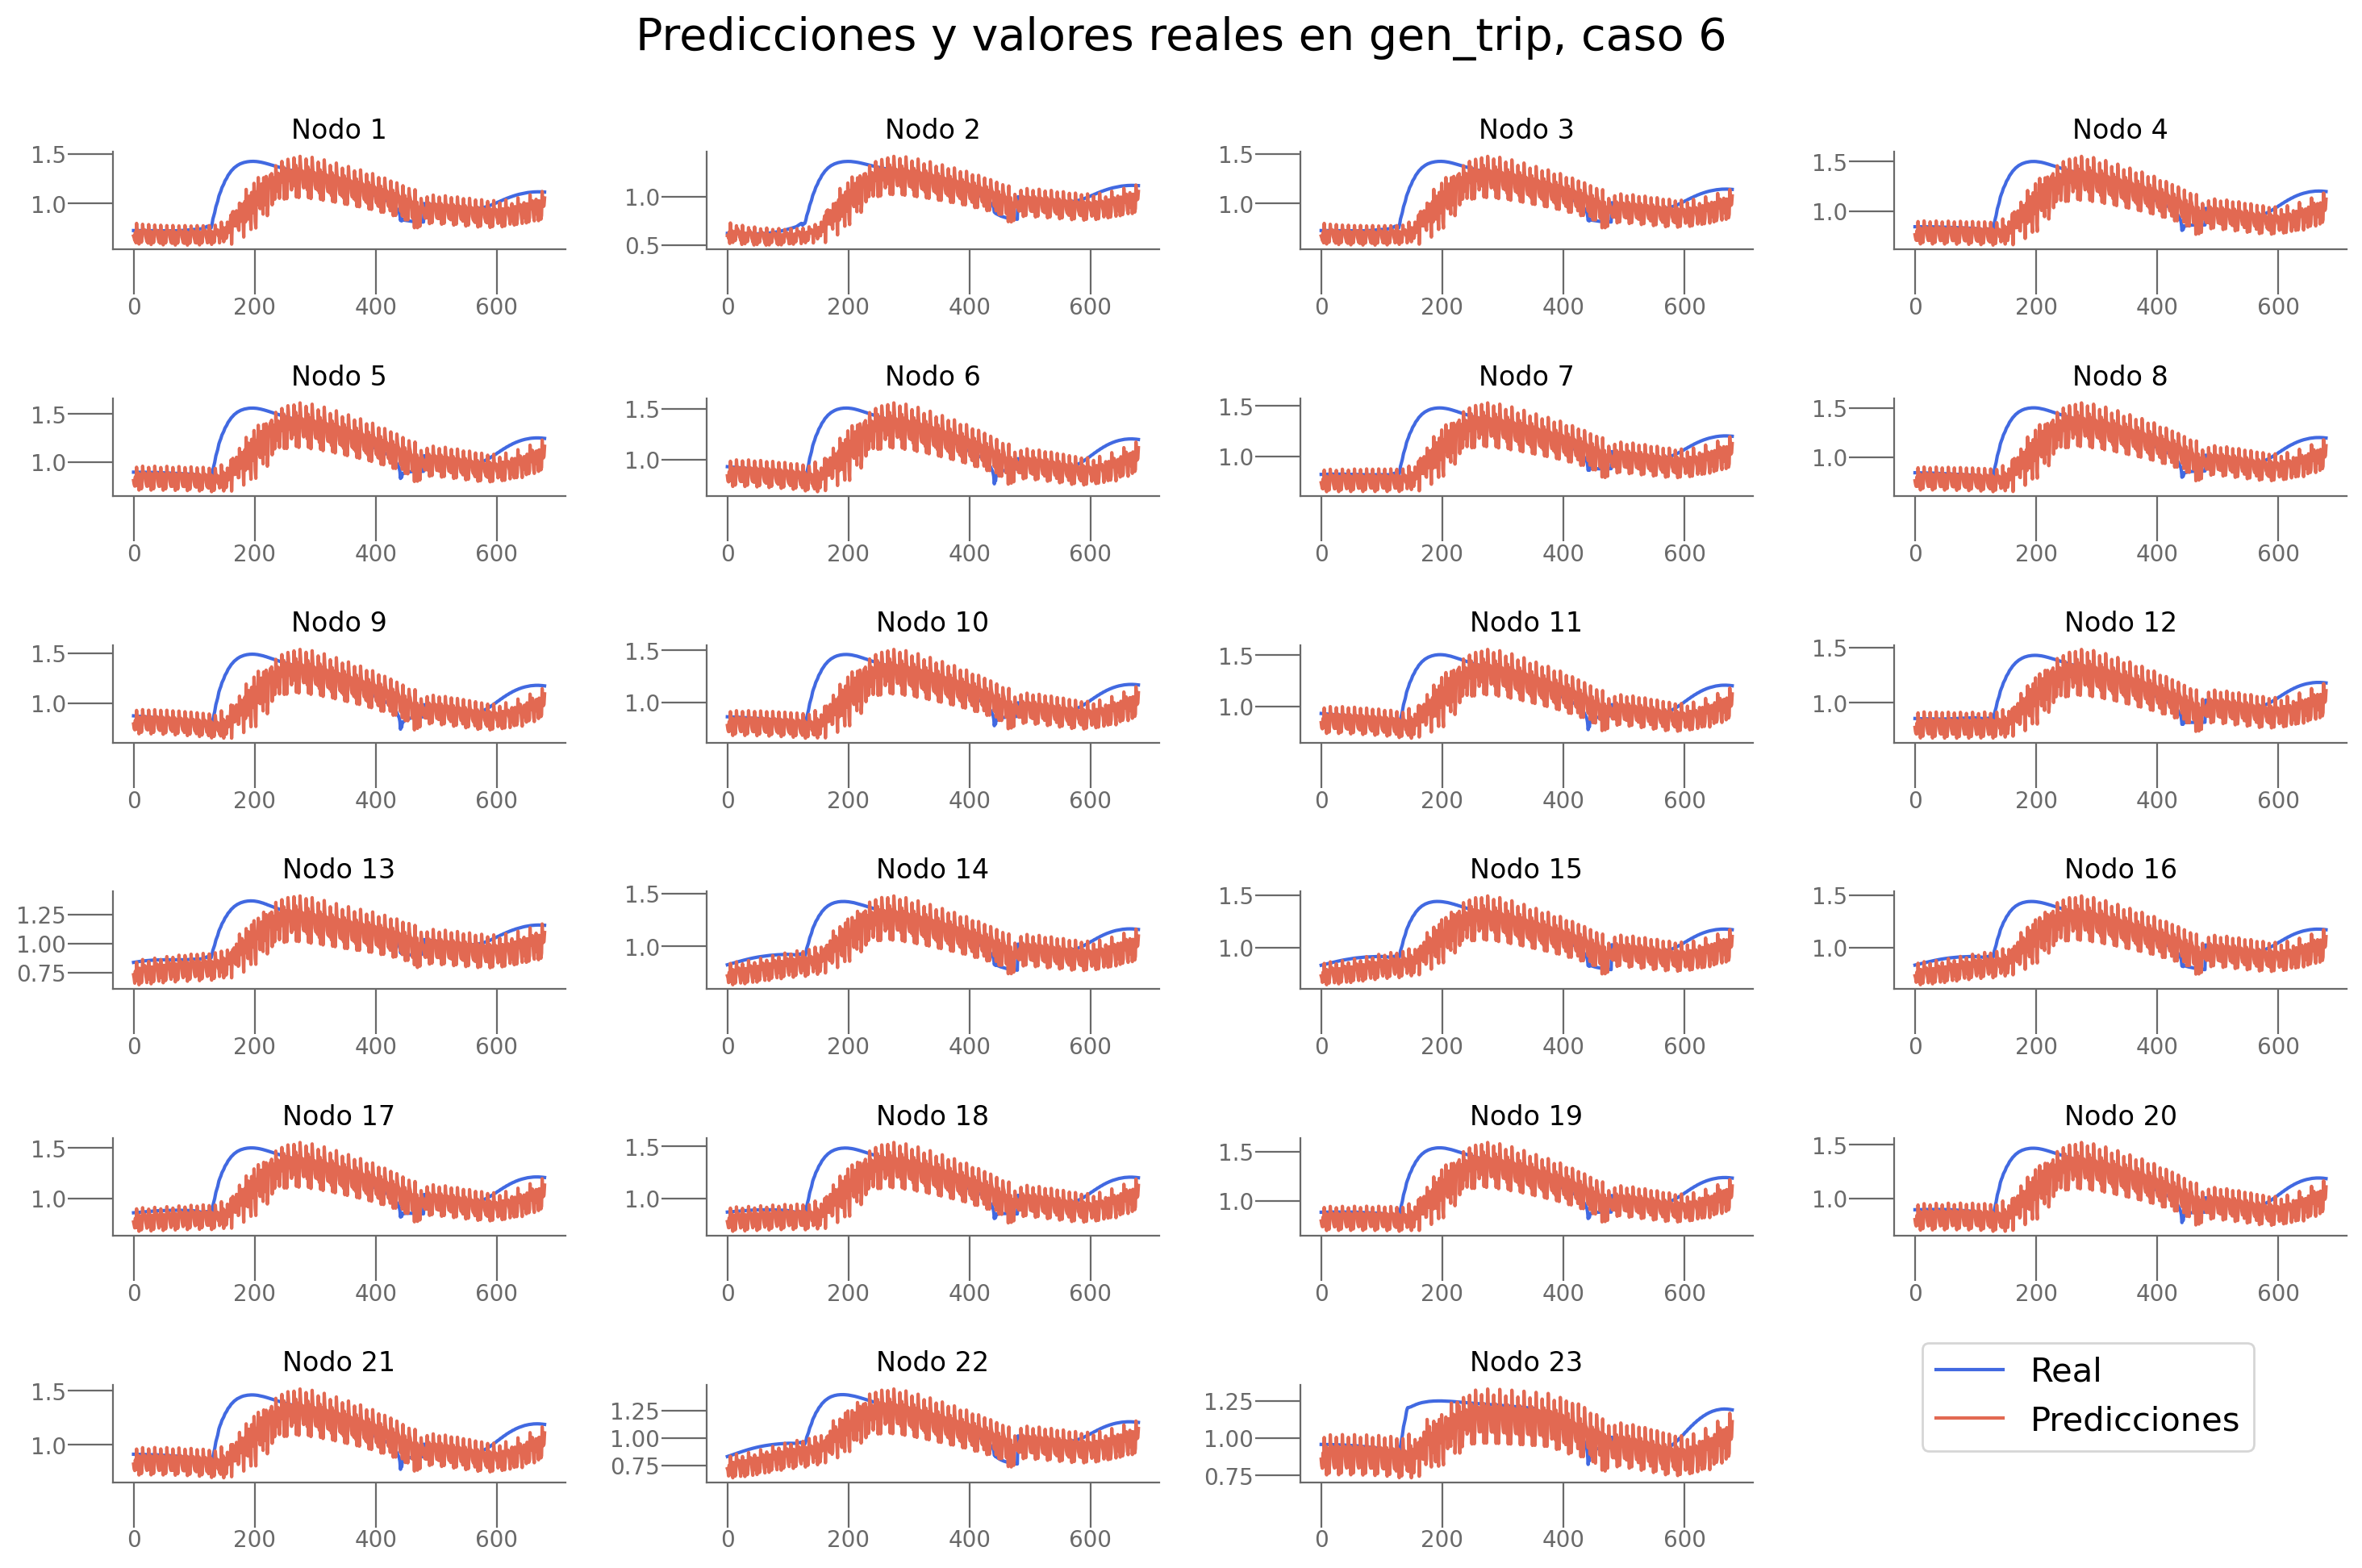

In [ ]:
plot_predictions(predictions, real, n_target, 6, n_div_gt, problem_gt)

In [ ]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [ ]:
trainer_gt.save_model(params=params_gt, path_save_experiment= path_save_experiment_gt)


==================== GUARDANDO RESULTADOS ===================

      Modelo                               Params  \
0       LSTM                                  NaN   
1  MPNN_LSTM  {'hidden_size': 16, 'dropout': 0.2}   

                    Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                              NaN  0.007638   0.204209   
1  ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   

                                          Loss_nodes    R2_eval  Loss_eval  \
0  [0.00403222 0.0036478  0.00494586 0.00812658 0...   0.341164   0.009765   
1  [0.04005108401179314, 0.03960233926773071, 0.0... -16.743964   0.052820   

   Loss_final  
0    0.008689  
1    0.059339  

==================== RESULTADOS GUARDADOS ===================



### Bus trip

In [ ]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [ ]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]


num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [ ]:

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model_bt = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=30,k=2, kernel_size=5, hidden_channels=16, normalization="sym")

trainer_bt = TrainerSTConv(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1429 | Eval Loss: 0.0324 | Eval R2: 0.2921 | 
Epoch 2/30 | Train Loss: 0.0273 | Eval Loss: 0.0251 | Eval R2: 0.4668 | 
Epoch 3/30 | Train Loss: 0.0220 | Eval Loss: 0.0213 | Eval R2: 0.5449 | 
Epoch 4/30 | Train Loss: 0.0187 | Eval Loss: 0.0183 | Eval R2: 0.6088 | 
Epoch 5/30 | Train Loss: 0.0161 | Eval Loss: 0.0160 | Eval R2: 0.6577 | 
Epoch 6/30 | Train Loss: 0.0141 | Eval Loss: 0.0143 | Eval R2: 0.6945 | 
Epoch 7/30 | Train Loss: 0.0126 | Eval Loss: 0.0130 | Eval R2: 0.7228 | 
Epoch 8/30 | Train Loss: 0.0115 | Eval Loss: 0.0119 | Eval R2: 0.7446 | 
Epoch 9/30 | Train Loss: 0.0106 | Eval Loss: 0.0111 | Eval R2: 0.7614 | 
Epoch 10/30 | Train Loss: 0.0099 | Eval Loss: 0.0105 | Eval R2: 0.7747 | 
Epoch 11/30 | Train Loss: 0.0093 | Eval Loss: 0.0100 | Eval R2: 0.7855 | 
Epoch 12/30 | Train Los

AxisError: axis 1 is out of bounds for array of dimension 1

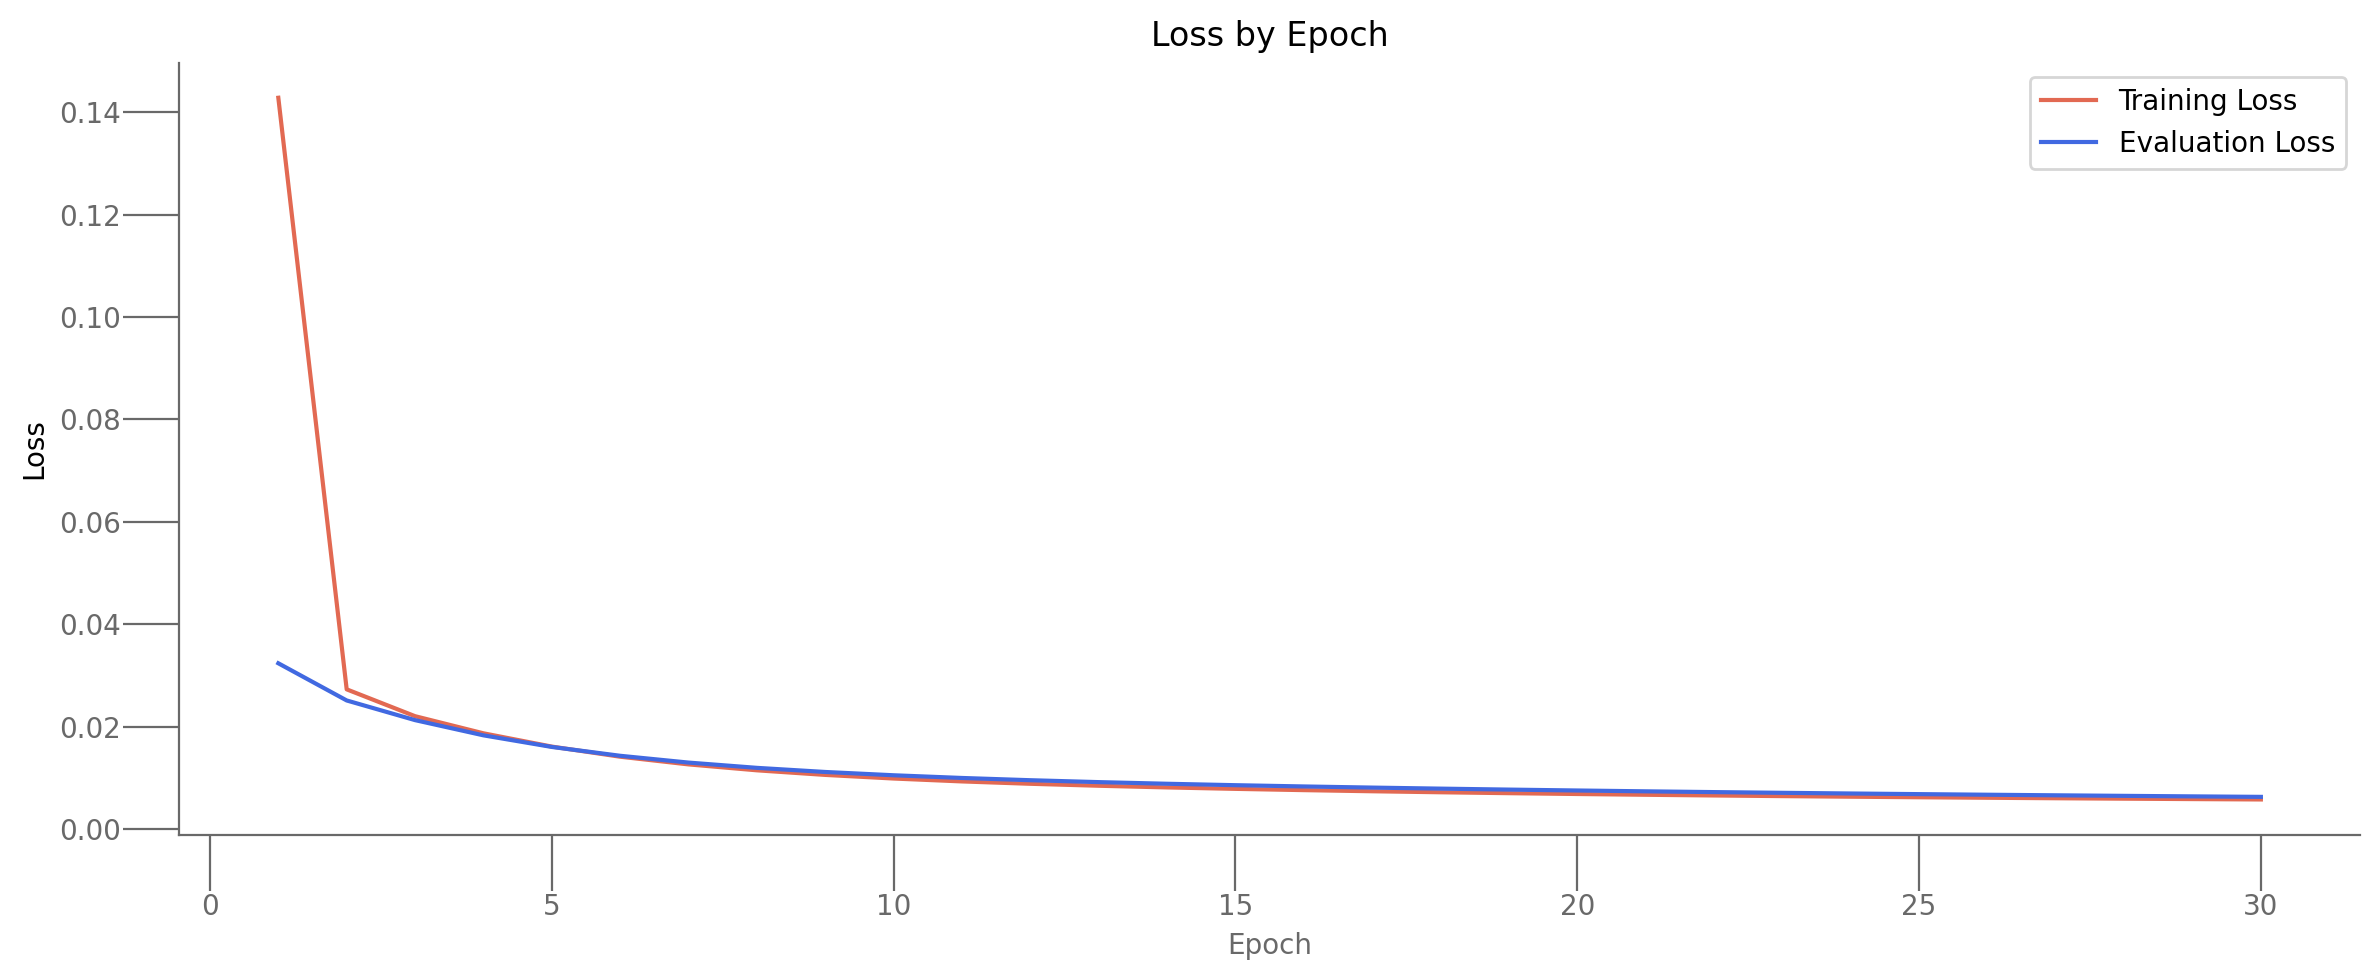


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006756, test r2score 0.845777


In [ ]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()

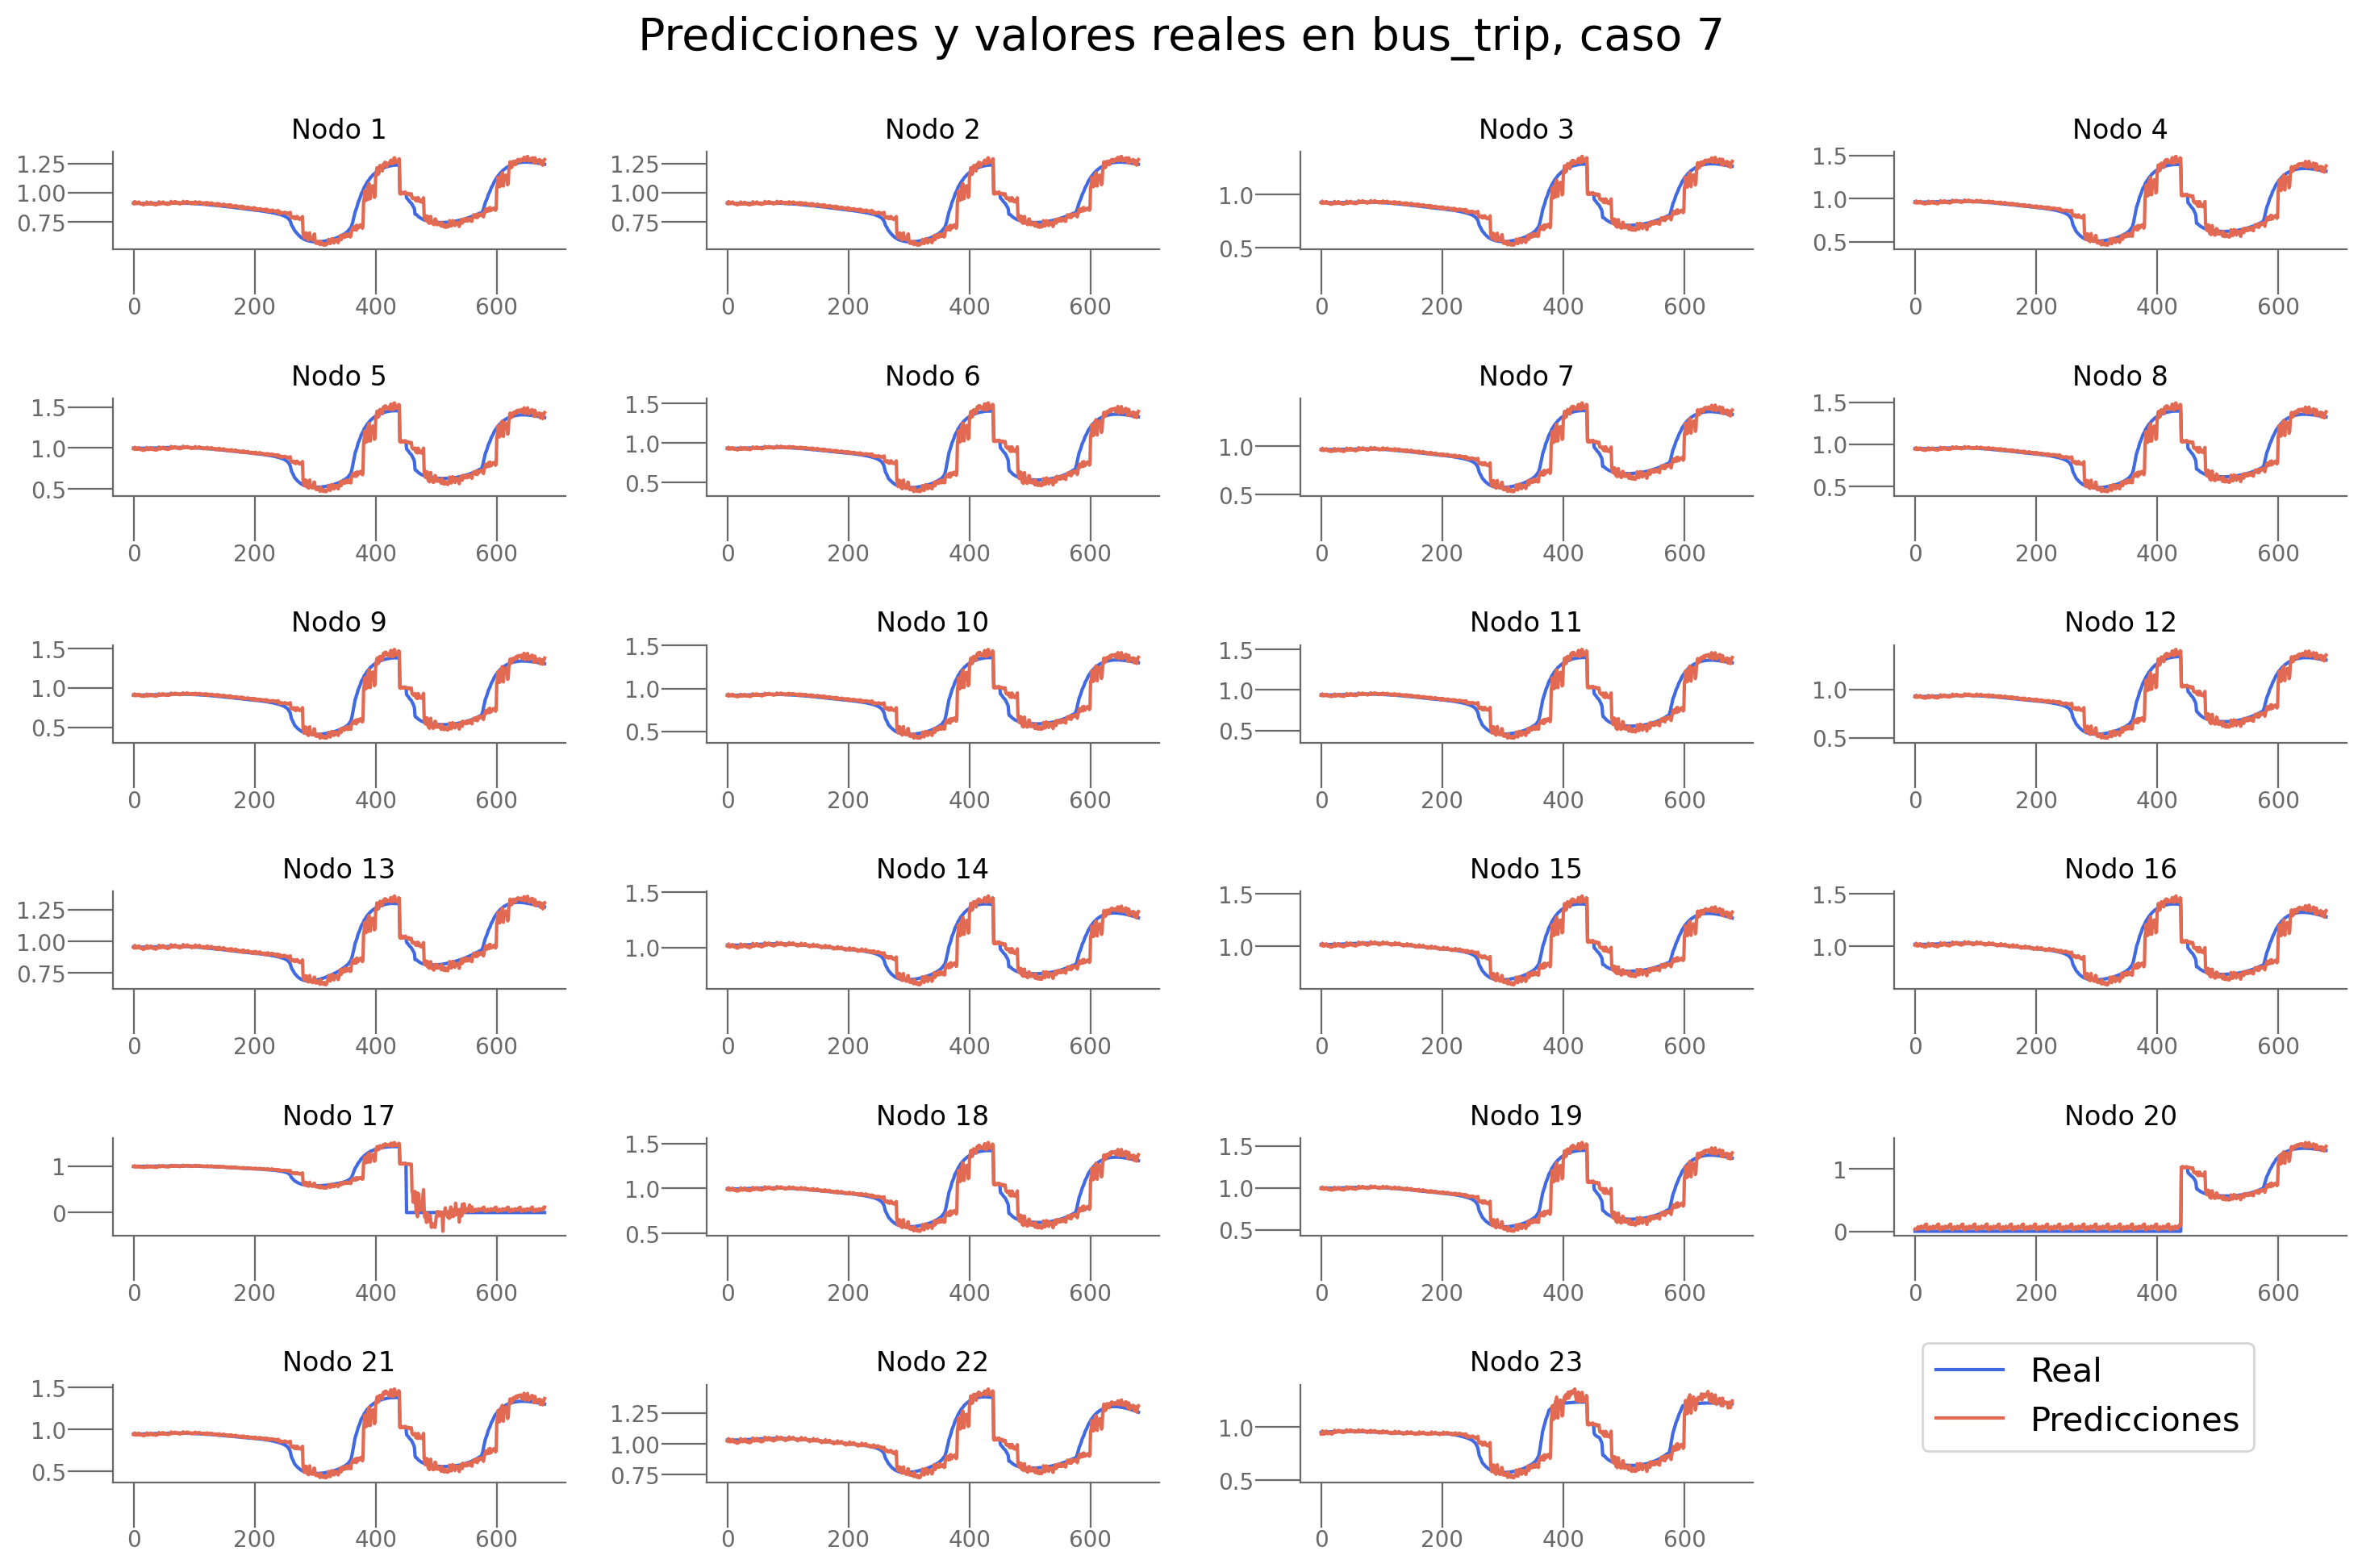

In [ ]:
plot_predictions(predictions_bt, real_bt, n_target, 7, n_div_bt, problem_bt)

#### Ajuste de parámetros 

In [ ]:
param_grid = {
    "out_channels": [16, 32, 64],
    "kernel_size": [3,5,7],
    "normalization": ["sym", "rw"],
    "hidden_channels": [16, 32, 64],
}

trainer_bt,params_bt,resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_stconv(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2183 | Eval Loss: 0.0378 | Eval R2: 0.1161 | 
Epoch 2/30 | Train Loss: 0.0295 | Eval Loss: 0.0276 | Eval R2: 0.4026 | 
Epoch 3/30 | Train Loss: 0.0245 | Eval Loss: 0.0241 | Eval R2: 0.4836 | 
Epoch 4/30 | Train Loss: 0.0213 | Eval Loss: 0.0211 | Eval R2: 0.5483 | 
Epoch 5/30 | Train Loss: 0.0187 | Eval Loss: 0.0187 | Eval R2: 0.6005 | 
Epoch 6/30 | Train Loss: 0.0165 | Eval Loss: 0.0167 | Eval R2: 0.6429 | 
Epoch 7/30 | Train Loss: 0.0148 | Eval Loss: 0.0151 | Eval R2: 0.6771 | 
Epoch 8/30 | Train Loss: 0.0134 | Eval Loss: 0.0139 | Eval R2: 0.7044 | 
Epoch 9/30 | Train Loss: 0.0123 | Eval Loss: 0.0128 | Eval R2: 0.7261 | 
Epoch 10/30 | Train Loss: 0.0114 | Eval Loss: 0.0120 | Eval R2: 0.7432 | 
Epoch 11/30 | Train Loss: 0.0107 | Eval Loss: 0.0114 | Eval R2: 0.7570 | 
Epoch 12/30 | Train Los

 11%|█         | 1/9 [26:13<3:29:49, 1573.73s/it]

preds:  (1, 23, 20)
test loss: 0.007729, test r2score 0.826042
Parámetros:  16 0.2
Resultados:  {'Hidden Size': 16, 'Dropout': 0.2, 'loss_final': 0.0063929324969649315, 'r2_eval_final': 0.8444012999534607, 'loss_eval_final': 0.007002599071711302, 'r2_test': 0.8260417420874909, 'loss_test': 0.007729331497102976, 'loss_nodes': [[0.0012316189240664244, 0.0025648542214185, 0.004232209641486406, 0.002245084149762988, 0.004455529153347015, 0.0031851588282734156, 0.004906906746327877, 0.007315126247704029, 0.006510755512863398, 0.007671521510928869, 0.007618315983563662, 0.007630873471498489, 0.008372261188924313, 0.00991574302315712, 0.008818774484097958, 0.012318135239183903, 0.013614100404083729, 0.011769616976380348, 0.014666534960269928, 0.015543511137366295]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2183 | Eval Loss: 0.0378 | Eval

 22%|██▏       | 2/9 [46:50<2:40:28, 1375.57s/it]

preds:  (1, 23, 20)
test loss: 0.007730, test r2score 0.826038
Parámetros:  16 0.5
Resultados:  {'Hidden Size': 16, 'Dropout': 0.5, 'loss_final': 0.006393061950802803, 'r2_eval_final': 0.8443971276283264, 'loss_eval_final': 0.007002798840403557, 'r2_test': 0.8260379652022487, 'loss_test': 0.007729538716375828, 'loss_nodes': [[0.0012337393127381802, 0.0025647731963545084, 0.004232246428728104, 0.0022451181430369616, 0.00445540901273489, 0.003185421694070101, 0.0049069891683757305, 0.007315138820558786, 0.006510025355964899, 0.0076723466627299786, 0.00761798582971096, 0.007631301414221525, 0.00837238784879446, 0.009915828704833984, 0.008818717673420906, 0.012318979017436504, 0.013614955358207226, 0.01176996249705553, 0.014666950330138206, 0.015542496927082539]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2184 | Eval Loss: 0.0378 | Eva

 33%|███▎      | 3/9 [1:08:35<2:14:20, 1343.43s/it]

preds:  (1, 23, 20)
test loss: 0.007730, test r2score 0.826025
Parámetros:  16 0.8
Resultados:  {'Hidden Size': 16, 'Dropout': 0.8, 'loss_final': 0.0063934302888810635, 'r2_eval_final': 0.844383180141449, 'loss_eval_final': 0.007003312464803457, 'r2_test': 0.8260250014167289, 'loss_test': 0.00773008493706584, 'loss_nodes': [[0.0012401235289871693, 0.0025644691195338964, 0.0042324005626142025, 0.002244965871796012, 0.00445533124729991, 0.0031855918932706118, 0.004906537011265755, 0.0073146941140294075, 0.006509754341095686, 0.007673825602978468, 0.007617775816470385, 0.007631735876202583, 0.008372814394533634, 0.009916701354086399, 0.00882065948098898, 0.012320036999881268, 0.013616005890071392, 0.01176946796476841, 0.014667200855910778, 0.015541624277830124]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1429 | Eval Loss: 0.0324 | Eva

 44%|████▍     | 4/9 [1:28:47<1:47:36, 1291.33s/it]

preds:  (1, 23, 20)
test loss: 0.006756, test r2score 0.845772
Parámetros:  32 0.2
Resultados:  {'Hidden Size': 32, 'Dropout': 0.2, 'loss_final': 0.005761419888585806, 'r2_eval_final': 0.8604593276977539, 'loss_eval_final': 0.006270183715969324, 'r2_test': 0.8457722728550151, 'loss_test': 0.006755925249308348, 'loss_nodes': [[0.0029735160060226917, 0.002852431032806635, 0.0023437689524143934, 0.0036082917358726263, 0.00366353802382946, 0.005451655946671963, 0.0034470560494810343, 0.00343154976144433, 0.0063123032450675964, 0.004125010687857866, 0.007013693451881409, 0.008087375201284885, 0.007997778244316578, 0.007289448287338018, 0.008682362735271454, 0.008492237888276577, 0.009901990182697773, 0.01119635347276926, 0.013659914024174213, 0.014588224701583385]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1429 | Eval Loss: 0.0324 | Ev

 56%|█████▌    | 5/9 [1:48:42<1:23:47, 1256.82s/it]

preds:  (1, 23, 20)
test loss: 0.006756, test r2score 0.845777
Parámetros:  32 0.5
Resultados:  {'Hidden Size': 32, 'Dropout': 0.5, 'loss_final': 0.0057615297846496105, 'r2_eval_final': 0.8604680299758911, 'loss_eval_final': 0.006270179990679026, 'r2_test': 0.8457769146634115, 'loss_test': 0.0067560067400336266, 'loss_nodes': [[0.002973308088257909, 0.0028528496623039246, 0.002343465806916356, 0.0036087152548134327, 0.0036633347626775503, 0.005452415440231562, 0.0034464027266949415, 0.0034266002476215363, 0.006312603130936623, 0.004124886821955442, 0.007014716975390911, 0.008087334223091602, 0.007998486049473286, 0.007290847133845091, 0.008682124316692352, 0.008491146378219128, 0.009904330596327782, 0.011196213774383068, 0.013659662567079067, 0.014590727165341377]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1427 | Eval Loss: 0.0322

 67%|██████▋   | 6/9 [2:08:54<1:02:04, 1241.61s/it]

preds:  (1, 23, 20)
test loss: 0.006753, test r2score 0.845855
Parámetros:  32 0.8
Resultados:  {'Hidden Size': 32, 'Dropout': 0.8, 'loss_final': 0.005759728606790304, 'r2_eval_final': 0.8606055974960327, 'loss_eval_final': 0.006266528740525246, 'r2_test': 0.8458545760100994, 'loss_test': 0.006752815563231707, 'loss_nodes': [[0.0029729458037763834, 0.002853402169421315, 0.0023424418177455664, 0.003609695238992572, 0.003664678195491433, 0.005453598685562611, 0.0034450555685907602, 0.0033521291334182024, 0.0063133989460766315, 0.004124844912439585, 0.007016718853265047, 0.008086179383099079, 0.007999027147889137, 0.00729392608627677, 0.008681918494403362, 0.008488642983138561, 0.00990616250783205, 0.011196495965123177, 0.013661309145390987, 0.014593721367418766]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1560 | Eval Loss: 0.0351 | E

 78%|███████▊  | 7/9 [2:29:43<41:27, 1243.93s/it]  

preds:  (1, 23, 20)
test loss: 0.007307, test r2score 0.834616
Parámetros:  64 0.2
Resultados:  {'Hidden Size': 64, 'Dropout': 0.2, 'loss_final': 0.006143319886177778, 'r2_eval_final': 0.8478742837905884, 'loss_eval_final': 0.006756979506462812, 'r2_test': 0.8346157823621578, 'loss_test': 0.007307019550353289, 'loss_nodes': [[0.0018815322546288371, 0.0020474253688007593, 0.004339874722063541, 0.0032204422168433666, 0.004250580910593271, 0.003734636353328824, 0.004178110044449568, 0.004100400488823652, 0.005941236391663551, 0.006818529684096575, 0.009209279902279377, 0.007458110339939594, 0.008753808215260506, 0.009247884154319763, 0.009174130856990814, 0.01151319034397602, 0.012735670432448387, 0.01229262538254261, 0.0114853261038661, 0.013757605105638504]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1560 | Eval Loss: 0.0351 | Eval 

 89%|████████▉ | 8/9 [2:49:49<20:31, 1231.93s/it]

preds:  (1, 23, 20)
test loss: 0.007307, test r2score 0.834622
Parámetros:  64 0.5
Resultados:  {'Hidden Size': 64, 'Dropout': 0.5, 'loss_final': 0.00614317599684, 'r2_eval_final': 0.8478814363479614, 'loss_eval_final': 0.006756696850061417, 'r2_test': 0.8346223947503953, 'loss_test': 0.007306717336177826, 'loss_nodes': [[0.0018820513505488634, 0.0020475273486226797, 0.004338002763688564, 0.003218886209651828, 0.004250187426805496, 0.0037341504357755184, 0.004178277682512999, 0.004101112484931946, 0.005941428244113922, 0.006817641202360392, 0.009208611212670803, 0.0074570742435753345, 0.008753079921007156, 0.00924717914313078, 0.009174240753054619, 0.011513350531458855, 0.012735390104353428, 0.012292145751416683, 0.011486171744763851, 0.013757863081991673]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1559 | Eval Loss: 0.0351 | Eval 

100%|██████████| 9/9 [3:09:24<00:00, 1262.68s/it]

preds:  (1, 23, 20)
test loss: 0.007306, test r2score 0.834633
Parámetros:  64 0.8
Resultados:  {'Hidden Size': 64, 'Dropout': 0.8, 'loss_final': 0.006142839323729277, 'r2_eval_final': 0.8478927612304688, 'loss_eval_final': 0.0067562079057097435, 'r2_test': 0.8346333073386368, 'loss_test': 0.007306231651455164, 'loss_nodes': [[0.001882542739622295, 0.002046376233920455, 0.004338377621024847, 0.0032168435864150524, 0.004249310586601496, 0.0037325385492295027, 0.004178372211754322, 0.004100453108549118, 0.005941395647823811, 0.006816148292273283, 0.009207842871546745, 0.007455659098923206, 0.008751618675887585, 0.009247017093002796, 0.00917421467602253, 0.011515764519572258, 0.012734461575746536, 0.012291652150452137, 0.011486013419926167, 0.013758046552538872]]}


In [ ]:
_, _, _, predictions_bt_ajuste, real_bt_ajuste = trainer_bt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006753, test r2score 0.845855


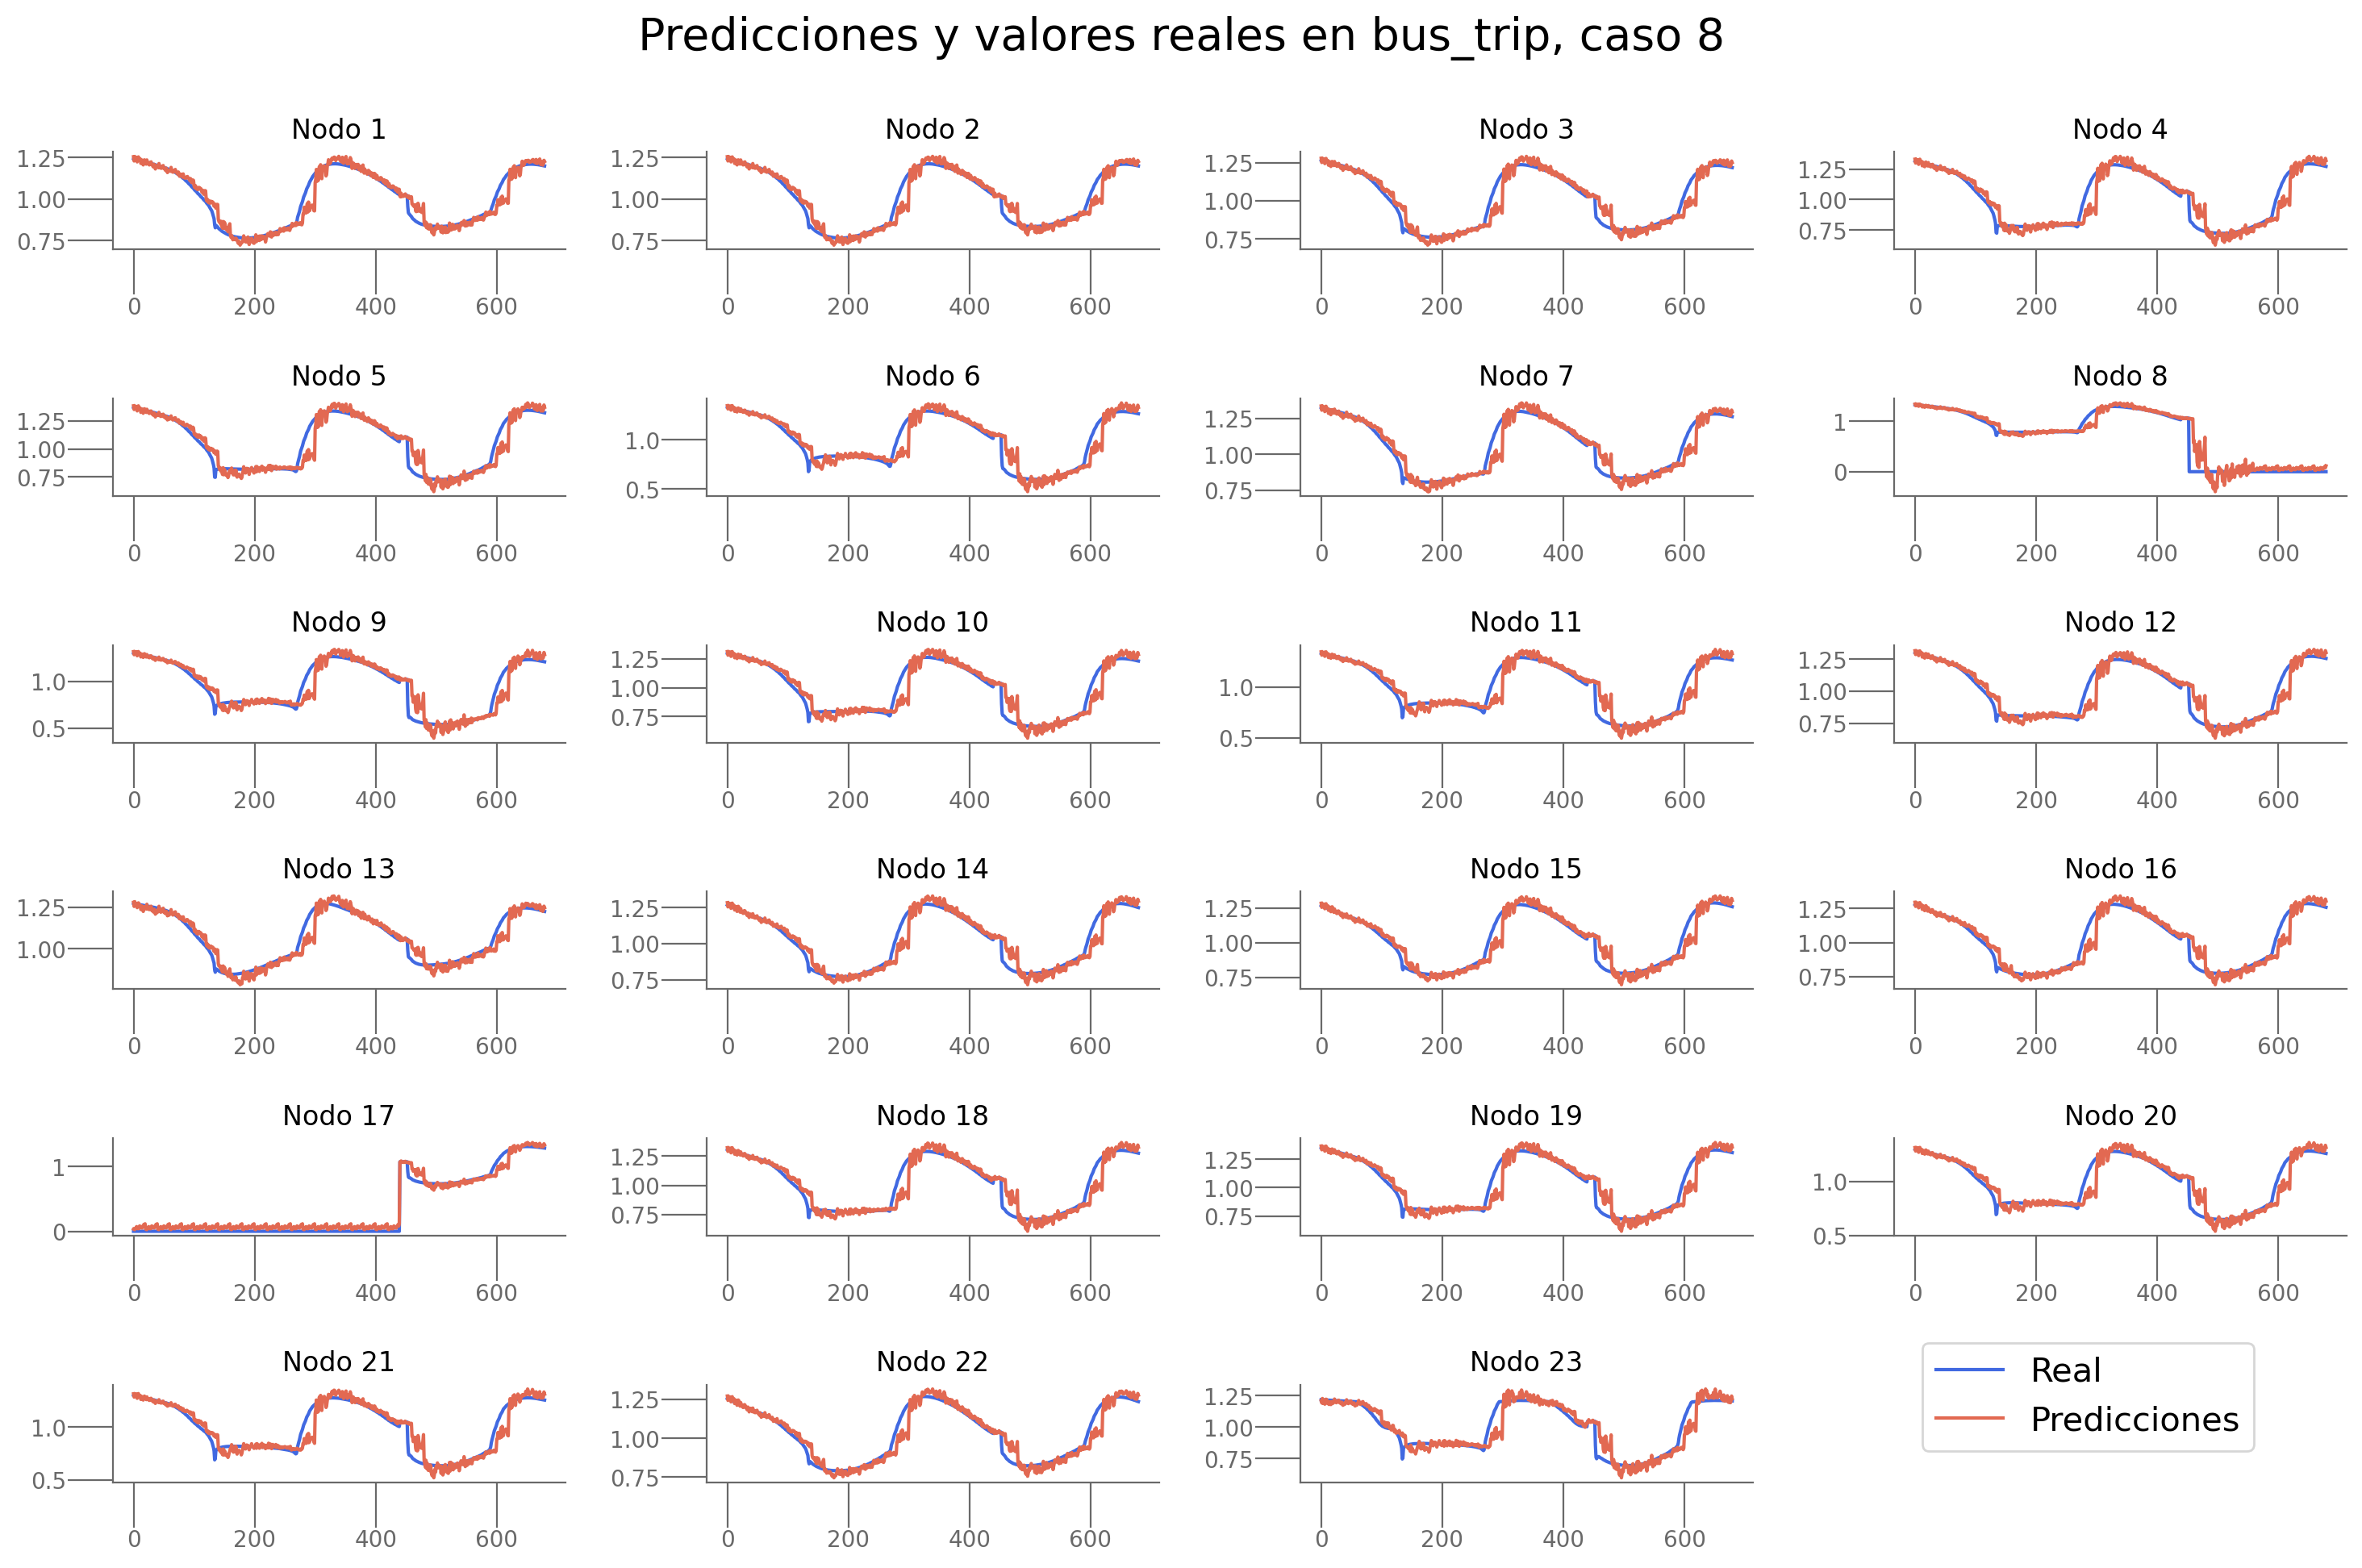

In [ ]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 8, n_div_bt, problem_bt)

In [ ]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [ ]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params=params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo     Params                   Fichero_resultados_experimento  \
0          LSTM        NaN                                              NaN   
1  LSTM_NOBATCH        NaN                                              NaN   
2     MPNN_LSTM  (32, 0.8)  ./results/bus_trip/ajustes/MPNNLSTM_results.csv   

   Loss_tst    R2_tst                                         Loss_nodes  \
0  0.005474  0.923150  [0.00273813 0.00319852 0.00392416 0.00609108 0...   
1  0.005606  0.865487  [0.00647055 0.0064651  0.00489909 0.00683031 0...   
2  0.006753  0.845855  [[0.0029729458, 0.0028534022, 0.0023424418, 0....   

    R2_eval  Loss_eval  Loss_final  loss_final  r2_eval_final  loss_eval_final  
0  0.912320   0.005448    0.005502         NaN            NaN              NaN  
1  0.871289   0.005549    0.005489         NaN            NaN              NaN  
2  0.000000   0.000000    0.000000     0.00576       0.860606         0

### Bus fault

In [ ]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [ ]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [ ]:

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model_bf = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=30,k=2, kernel_size=5, hidden_channels=16, normalization="sym")

trainer_bf = TrainerSTConv(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1067 | Eval Loss: 0.0631 | Eval R2: -7.6040 | 
Epoch 2/30 | Train Loss: 0.0396 | Eval Loss: 0.0499 | Eval R2: -5.4008 | 
Epoch 3/30 | Train Loss: 0.0324 | Eval Loss: 0.0433 | Eval R2: -4.4827 | 
Epoch 4/30 | Train Loss: 0.0283 | Eval Loss: 0.0391 | Eval R2: -3.8610 | 
Epoch 5/30 | Train Loss: 0.0257 | Eval Loss: 0.0363 | Eval R2: -3.4441 | 
Epoch 6/30 | Train Loss: 0.0241 | Eval Loss: 0.0344 | Eval R2: -3.1573 | 
Epoch 7/30 | Train Loss: 0.0229 | Eval Loss: 0.0330 | Eval R2: -2.9501 | 
Epoch 8/30 | Train Loss: 0.0220 | Eval Loss: 0.0320 | Eval R2: -2.7942 | 
Epoch 9/30 | Train Loss: 0.0214 | Eval Loss: 0.0311 | Eval R2: -2.6735 | 
Epoch 10/30 | Train Loss: 0.0208 | Eval Loss: 0.0304 | Eval R2: -2.5770 | 
Epoch 11/30 | Train Loss: 0.0203 | Eval Loss: 0.0298 | Eval R2: -2.4974 | 
Epoch 12/30 

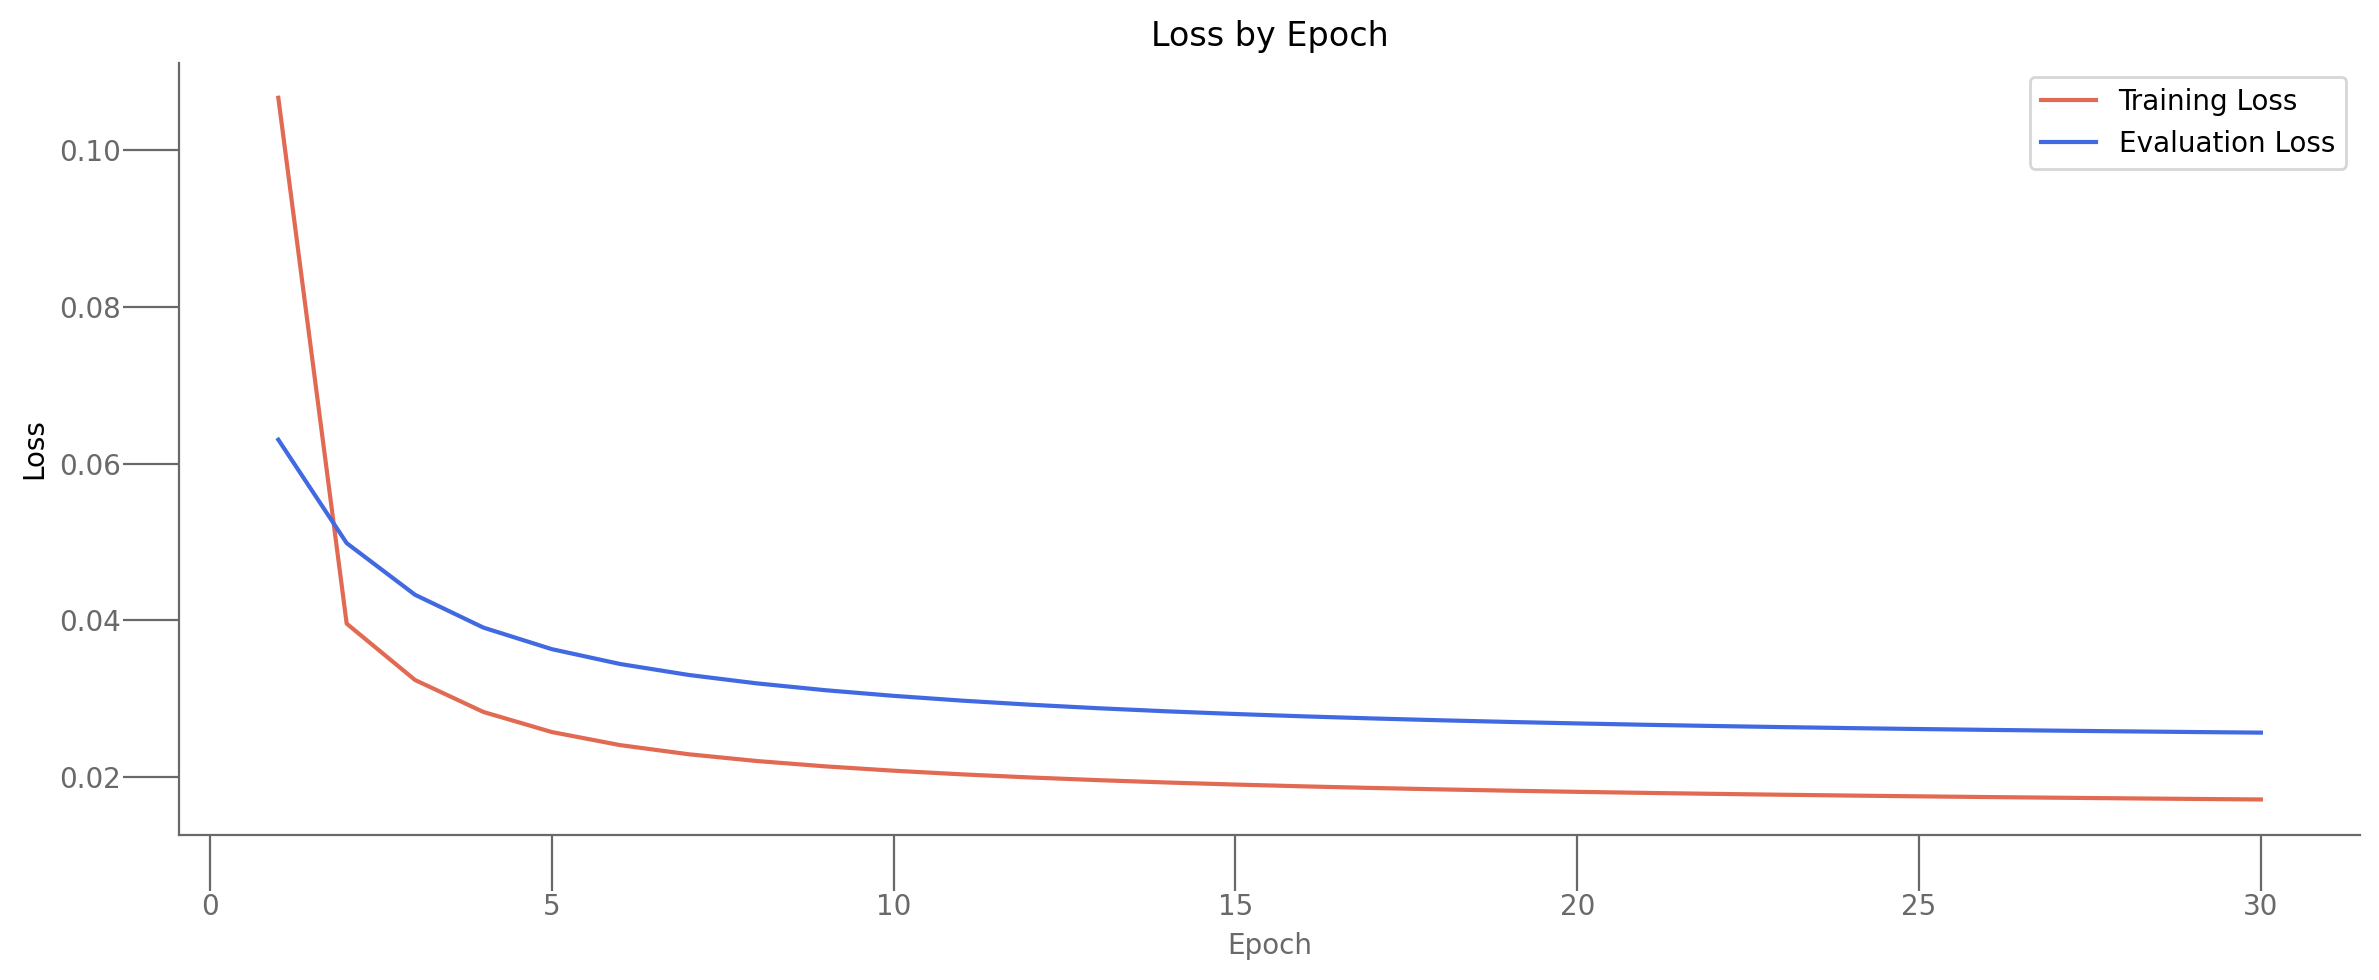


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.016833, test r2score -0.702392


In [ ]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()

#### Ajuste de parámetros 

In [ ]:
param_grid = {
    "out_channels": [16, 32, 64],
    "kernel_size": [3,5,7],
    "normalization": ["sym", "rw"],
    "hidden_channels": [16, 32, 64],
}
trainer_bf,params_bf,resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_stconv(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1448 | Eval Loss: 0.0662 | Eval R2: -8.0528 | 
Epoch 2/30 | Train Loss: 0.0427 | Eval Loss: 0.0541 | Eval R2: -6.0254 | 
Epoch 3/30 | Train Loss: 0.0357 | Eval Loss: 0.0471 | Eval R2: -5.1078 | 
Epoch 4/30 | Train Loss: 0.0311 | Eval Loss: 0.0424 | Eval R2: -4.4170 | 
Epoch 5/30 | Train Loss: 0.0281 | Eval Loss: 0.0392 | Eval R2: -3.9177 | 
Epoch 6/30 | Train Loss: 0.0261 | Eval Loss: 0.0370 | Eval R2: -3.5605 | 
Epoch 7/30 | Train Loss: 0.0247 | Eval Loss: 0.0353 | Eval R2: -3.3015 | 
Epoch 8/30 | Train Loss: 0.0236 | Eval Loss: 0.0341 | Eval R2: -3.1077 | 
Epoch 9/30 | Train Loss: 0.0228 | Eval Loss: 0.0331 | Eval R2: -2.9567 | 
Epoch 10/30 | Train Loss: 0.0222 | Eval Loss: 0.0322 | Eval R2: -2.8340 | 
Epoch 11/30 | Train Loss: 0.0216 | Eval Loss: 0.0314 | Eval R2: -2.7312 | 
Epoch 12/30 

 11%|█         | 1/9 [18:45<2:30:02, 1125.27s/it]

preds:  (1, 23, 20)
test loss: 0.016847, test r2score -0.674605
Parámetros:  16 0.2
Resultados:  {'Hidden Size': 16, 'Dropout': 0.2, 'loss_final': 0.017502643167972565, 'r2_eval_final': -2.02036452293396, 'loss_eval_final': 0.02577253058552742, 'r2_test': -0.674604530194672, 'loss_test': 0.016847403720021248, 'loss_nodes': [[0.0032973187044262886, 0.005990571808069944, 0.007124859839677811, 0.008016572333872318, 0.008754278533160686, 0.009407425299286842, 0.01383285317569971, 0.014305764809250832, 0.016614625230431557, 0.015717213973402977, 0.018546277657151222, 0.02029373310506344, 0.02343233861029148, 0.023798810318112373, 0.024233819916844368, 0.022959420457482338, 0.02336125262081623, 0.025973455980420113, 0.02496693655848503, 0.02632051333785057]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1448 | Eval Loss: 0.0662 | Eval R2: -

 22%|██▏       | 2/9 [47:55<2:54:09, 1492.73s/it]

preds:  (1, 23, 20)
test loss: 0.016847, test r2score -0.674610
Parámetros:  16 0.5
Resultados:  {'Hidden Size': 16, 'Dropout': 0.5, 'loss_final': 0.017502708360552788, 'r2_eval_final': -2.0203819274902344, 'loss_eval_final': 0.02577260695397854, 'r2_test': -0.674610484723791, 'loss_test': 0.016847405582666397, 'loss_nodes': [[0.0032976444344967604, 0.0059906188398599625, 0.0071248929016292095, 0.008016480132937431, 0.008754287846386433, 0.009408222511410713, 0.013832979835569859, 0.014305762015283108, 0.016614457592368126, 0.015717193484306335, 0.01854620687663555, 0.02029361017048359, 0.02343226596713066, 0.023798760026693344, 0.024233773350715637, 0.022959312424063683, 0.023360976949334145, 0.025973469018936157, 0.024966834113001823, 0.02632037177681923]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1449 | Eval Loss: 0.0662 | Eval

 33%|███▎      | 3/9 [1:04:58<2:07:49, 1278.20s/it]

preds:  (1, 23, 20)
test loss: 0.016847, test r2score -0.674628
Parámetros:  16 0.8
Resultados:  {'Hidden Size': 16, 'Dropout': 0.8, 'loss_final': 0.017502756789326668, 'r2_eval_final': -2.020406723022461, 'loss_eval_final': 0.02577274851500988, 'r2_test': -0.674628099171607, 'loss_test': 0.016847413033246994, 'loss_nodes': [[0.0032987117301672697, 0.005989863537251949, 0.007125079166144133, 0.00801664125174284, 0.008754244074225426, 0.009408858604729176, 0.013832592405378819, 0.01430560927838087, 0.016614362597465515, 0.015717213973402977, 0.018546218052506447, 0.020293492823839188, 0.023432040587067604, 0.023798614740371704, 0.024234145879745483, 0.022959211841225624, 0.0233607217669487, 0.025973670184612274, 0.024966726079583168, 0.02632029913365841]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1067 | Eval Loss: 0.0631 | Eval R2:

 44%|████▍     | 4/9 [1:21:26<1:36:59, 1163.95s/it]

preds:  (1, 23, 20)
test loss: 0.016833, test r2score -0.702347
Parámetros:  32 0.2
Resultados:  {'Hidden Size': 32, 'Dropout': 0.2, 'loss_final': 0.017141446471214294, 'r2_eval_final': -2.023106336593628, 'loss_eval_final': 0.02567320689558983, 'r2_test': -0.7023470879308162, 'loss_test': 0.01683320477604866, 'loss_nodes': [[0.004515401553362608, 0.005715459585189819, 0.00517646549269557, 0.007578704040497541, 0.009841090999543667, 0.01086998637765646, 0.013114871457219124, 0.013569999486207962, 0.015599321573972702, 0.0164334699511528, 0.019077034667134285, 0.020964089781045914, 0.02431243471801281, 0.024102941155433655, 0.024257035925984383, 0.02291356958448887, 0.02318396046757698, 0.02670777589082718, 0.023176830261945724, 0.025553692132234573]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1067 | Eval Loss: 0.0631 | Eval R2: -7.

 56%|█████▌    | 5/9 [1:37:29<1:12:45, 1091.32s/it]

preds:  (1, 23, 20)
test loss: 0.016833, test r2score -0.702392
Parámetros:  32 0.5
Resultados:  {'Hidden Size': 32, 'Dropout': 0.5, 'loss_final': 0.017141662538051605, 'r2_eval_final': -2.023175001144409, 'loss_eval_final': 0.025673573836684227, 'r2_test': -0.7023921043237396, 'loss_test': 0.016833487898111343, 'loss_nodes': [[0.004515343811362982, 0.005715853068977594, 0.005176701582968235, 0.0075788297690451145, 0.00984092429280281, 0.01087027508765459, 0.013115264475345612, 0.013573345728218555, 0.015599357895553112, 0.01643386483192444, 0.019077172502875328, 0.020964091643691063, 0.02431187592446804, 0.024102911353111267, 0.024257101118564606, 0.022913813591003418, 0.023184141144156456, 0.026708615943789482, 0.02317691221833229, 0.025553416460752487]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1068 | Eval Loss: 0.0631 | Eval R

 67%|██████▋   | 6/9 [1:54:30<53:22, 1067.58s/it]  

preds:  (1, 23, 20)
test loss: 0.016834, test r2score -0.702435
Parámetros:  32 0.8
Resultados:  {'Hidden Size': 32, 'Dropout': 0.8, 'loss_final': 0.017142098397016525, 'r2_eval_final': -2.023254632949829, 'loss_eval_final': 0.025673918426036835, 'r2_test': -0.702435180596883, 'loss_test': 0.016833795234560966, 'loss_nodes': [[0.0045151780359447, 0.005716928280889988, 0.005177121609449387, 0.007579033263027668, 0.00984183233231306, 0.01087114866822958, 0.013116065412759781, 0.013576808385550976, 0.01559941004961729, 0.01643388345837593, 0.019077524542808533, 0.02096439339220524, 0.02431095391511917, 0.02410280704498291, 0.024257047101855278, 0.022914370521903038, 0.023184284567832947, 0.026707902550697327, 0.023176254704594612, 0.02555306814610958]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1135 | Eval Loss: 0.0627 | Eval R2: -7.3

 78%|███████▊  | 7/9 [2:10:57<34:42, 1041.10s/it]

preds:  (1, 23, 20)
test loss: 0.016746, test r2score -0.682421
Parámetros:  64 0.2
Resultados:  {'Hidden Size': 64, 'Dropout': 0.2, 'loss_final': 0.017111370339989662, 'r2_eval_final': -1.9816094636917114, 'loss_eval_final': 0.02507169172167778, 'r2_test': -0.6824212038350321, 'loss_test': 0.01674562320113182, 'loss_nodes': [[0.0034881732426583767, 0.005533438175916672, 0.006349203176796436, 0.007582153659313917, 0.00847836583852768, 0.009342099539935589, 0.013646888546645641, 0.01342639047652483, 0.01612459495663643, 0.0172677431255579, 0.017787642776966095, 0.02139854244887829, 0.023261895403265953, 0.02320101670920849, 0.02497697062790394, 0.022271009162068367, 0.023962952196598053, 0.025888992473483086, 0.025596117600798607, 0.025328252464532852]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1134 | Eval Loss: 0.0627 | Eval R2: -

 89%|████████▉ | 8/9 [2:28:27<17:23, 1043.98s/it]

preds:  (1, 23, 20)
test loss: 0.016746, test r2score -0.682436
Parámetros:  64 0.5
Resultados:  {'Hidden Size': 64, 'Dropout': 0.5, 'loss_final': 0.017111273482441902, 'r2_eval_final': -1.981616497039795, 'loss_eval_final': 0.02507157437503338, 'r2_test': -0.6824362863658895, 'loss_test': 0.0167456716299057, 'loss_nodes': [[0.003488818183541298, 0.005533497780561447, 0.006348649505525827, 0.007582136429846287, 0.008478228934109211, 0.00934250745922327, 0.013646972365677357, 0.013426902703940868, 0.016124654561281204, 0.017267601564526558, 0.01778762973845005, 0.02139846235513687, 0.023261968046426773, 0.023201104253530502, 0.024976937100291252, 0.022271089255809784, 0.023963017389178276, 0.02588922530412674, 0.02559611387550831, 0.02532798796892166]]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1134 | Eval Loss: 0.0627 | Eval R2: -7

100%|██████████| 9/9 [3:26:02<00:00, 1373.64s/it]

preds:  (1, 23, 20)
test loss: 0.016746, test r2score -0.682477
Parámetros:  64 0.8
Resultados:  {'Hidden Size': 64, 'Dropout': 0.8, 'loss_final': 0.01711093820631504, 'r2_eval_final': -1.9816198348999023, 'loss_eval_final': 0.02507123537361622, 'r2_test': -0.6824773071926948, 'loss_test': 0.016745666041970253, 'loss_nodes': [[0.003488649148494005, 0.005533156916499138, 0.006348730996251106, 0.007581872865557671, 0.008477880619466305, 0.009343980811536312, 0.01364693883806467, 0.013426374644041061, 0.016124598681926727, 0.01726735383272171, 0.01778765581548214, 0.021398330107331276, 0.02326246351003647, 0.023201176896691322, 0.024976996704936028, 0.022270403802394867, 0.023963358253240585, 0.025889653712511063, 0.025596093386411667, 0.02532770484685898]]}


In [ ]:
_, _, _, predictions_bf_ajuste, real_bf_ajuste = trainer_bf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.016746, test r2score -0.682421


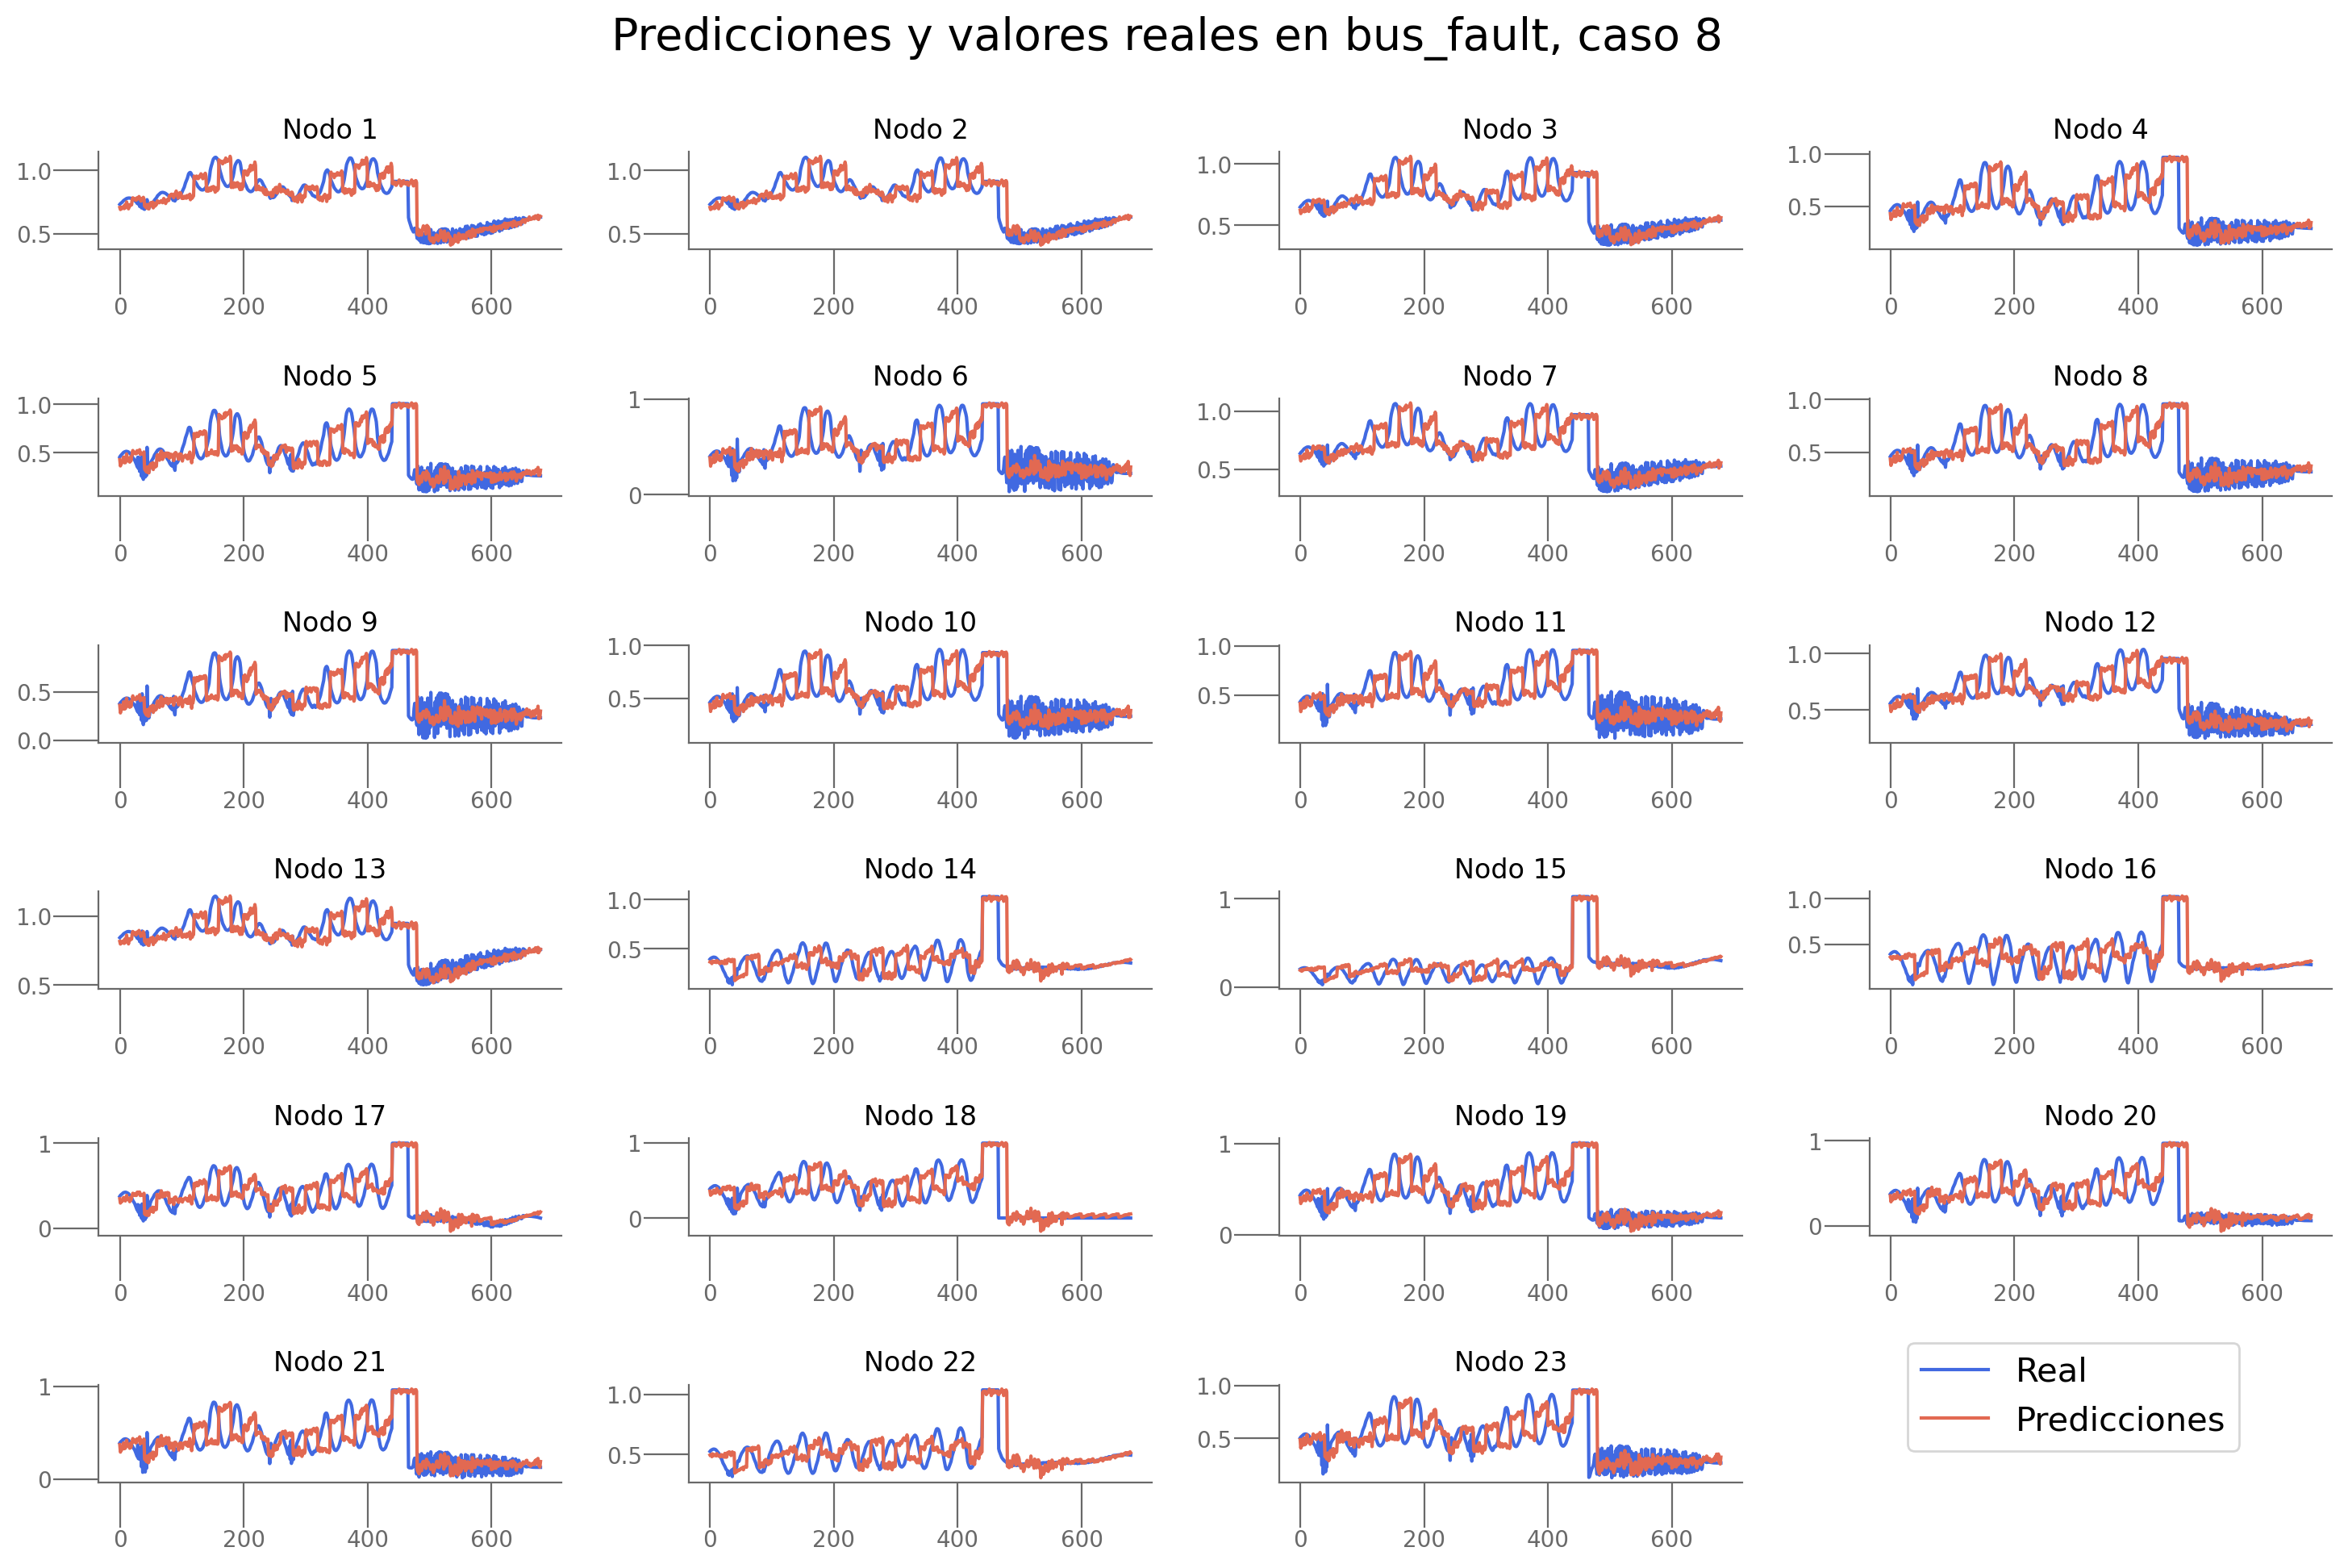

In [ ]:
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 8, n_div_bf, problem_bf)

In [ ]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)

In [ ]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params=params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                               Params  \
0          LSTM                                  NaN   
1  LSTM_NOBATCH                                  NaN   
2     MPNN_LSTM  {'hidden_size': 64, 'dropout': 0.2}   

                     Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                               NaN  0.017298  0.603716   
1                                               NaN  0.017459 -1.122112   
2  ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0107881  0.01006583 0.01300934 0.01969145 0...  0.541346   0.024664   
1  [0.01527361 0.01028231 0.01348895 0.01959247 0... -2.717829   0.025920   
2  [[0.0034881732, 0.005533438, 0.006349203, 0.00...  0.000000   0.000000   

   Loss_final  loss_final  r2_eval_final  loss_eval_final  
0    0.018978         NaN            NaN 

### Branch Fault

In [ ]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [ ]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [ ]:

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model_brf = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=30,k=2, kernel_size=5, hidden_channels=16, normalization="sym")

trainer_brf = TrainerSTConv(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1070 | Eval Loss: 0.0668 | Eval R2: -6.9243 | 
Epoch 2/30 | Train Loss: 0.0434 | Eval Loss: 0.0504 | Eval R2: -5.3042 | 
Epoch 3/30 | Train Loss: 0.0355 | Eval Loss: 0.0432 | Eval R2: -4.6012 | 
Epoch 4/30 | Train Loss: 0.0315 | Eval Loss: 0.0392 | Eval R2: -4.1786 | 
Epoch 5/30 | Train Loss: 0.0294 | Eval Loss: 0.0370 | Eval R2: -3.9406 | 
Epoch 6/30 | Train Loss: 0.0280 | Eval Loss: 0.0355 | Eval R2: -3.7719 | 
Epoch 7/30 | Train Loss: 0.0270 | Eval Loss: 0.0343 | Eval R2: -3.6157 | 
Epoch 8/30 | Train Loss: 0.0263 | Eval Loss: 0.0333 | Eval R2: -3.5037 | 
Epoch 9/30 | Train Loss: 0.0256 | Eval Loss: 0.0327 | Eval R2: -3.4450 | 
Epoch 10/30 | Train Loss: 0.0251 | Eval Loss: 0.0321 | Eval R2: -3.3860 | 
Epoch 11/30 | Train Loss: 0.0246 | Eval Loss: 0.0316 | Eval R2: -3.3182 | 
Epoch 12/30 

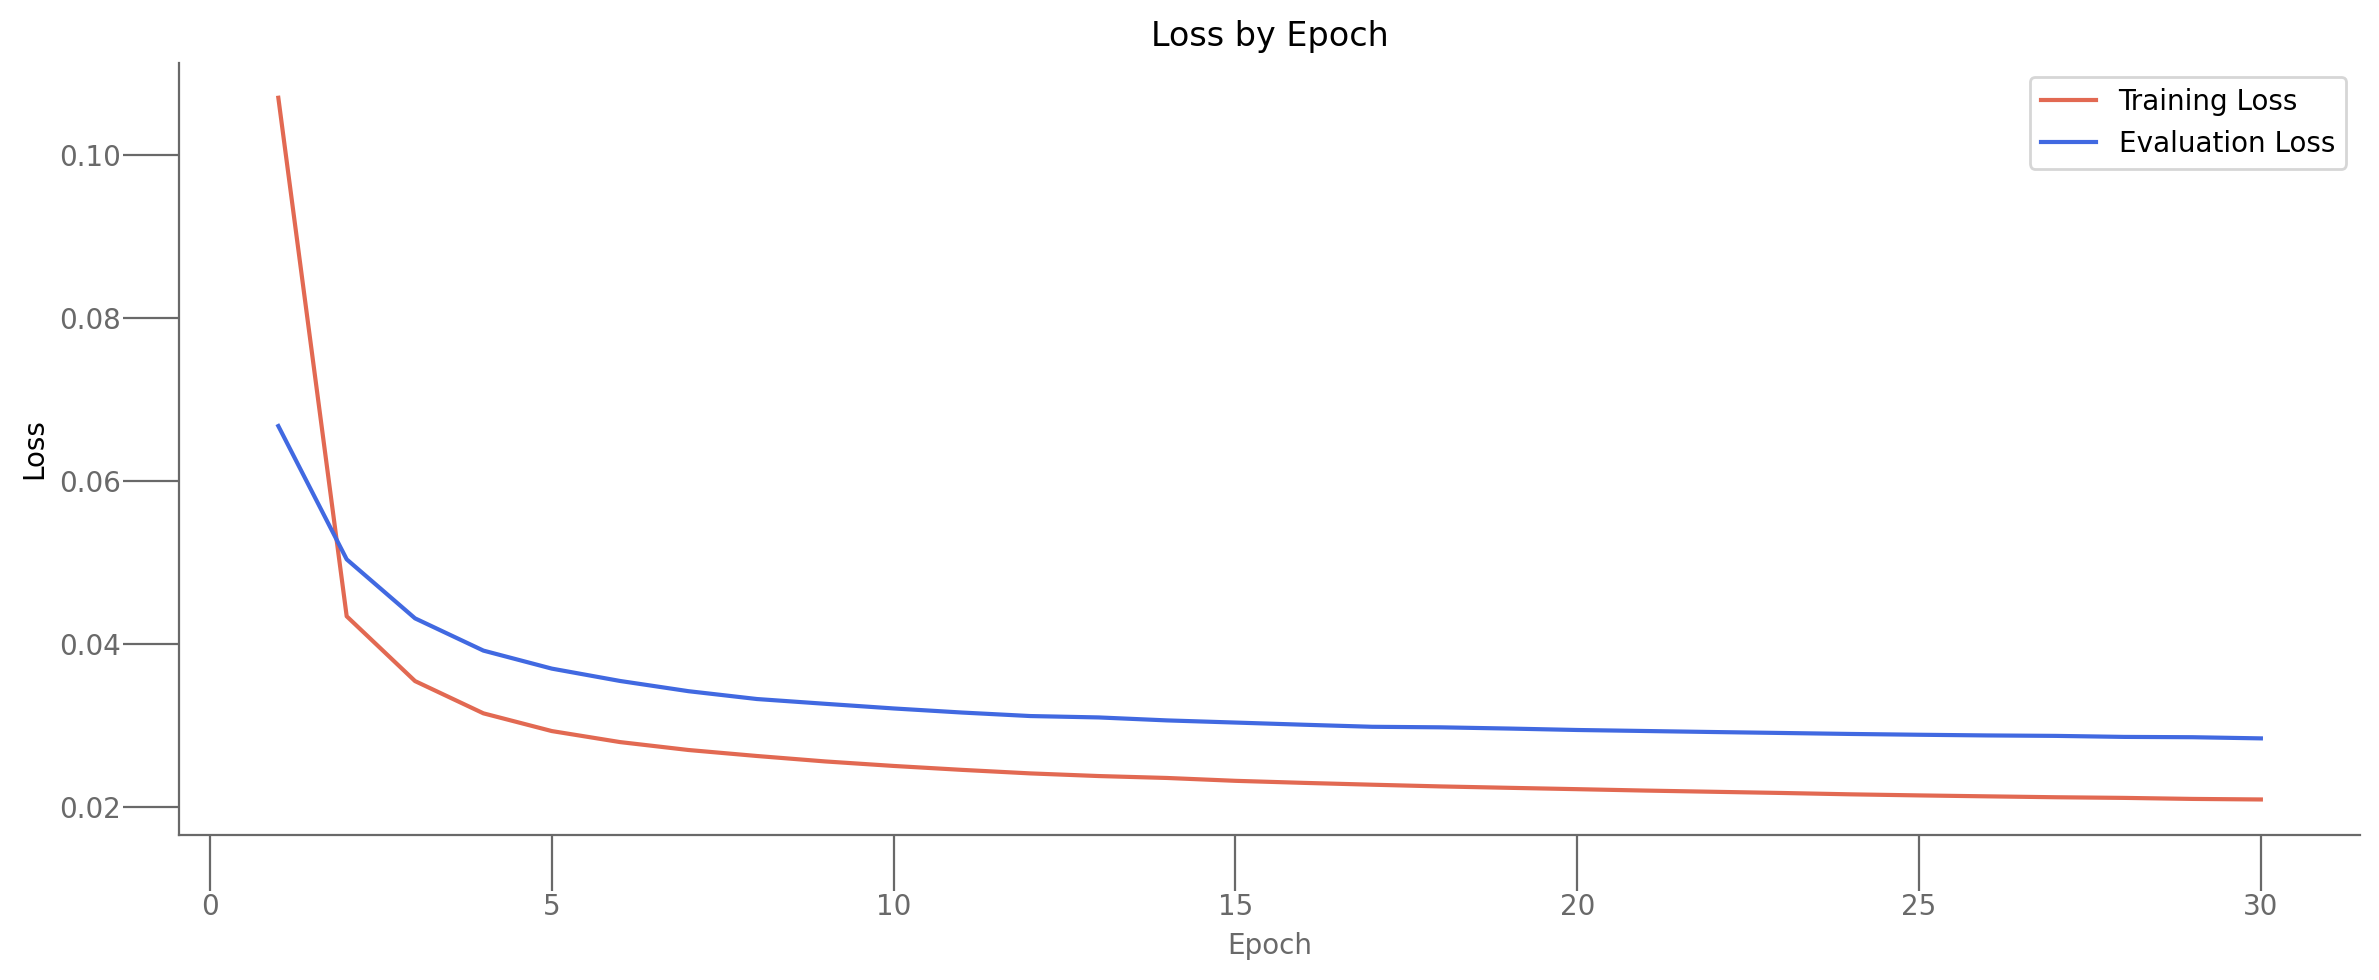


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.022143, test r2score -1.685531


In [ ]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()

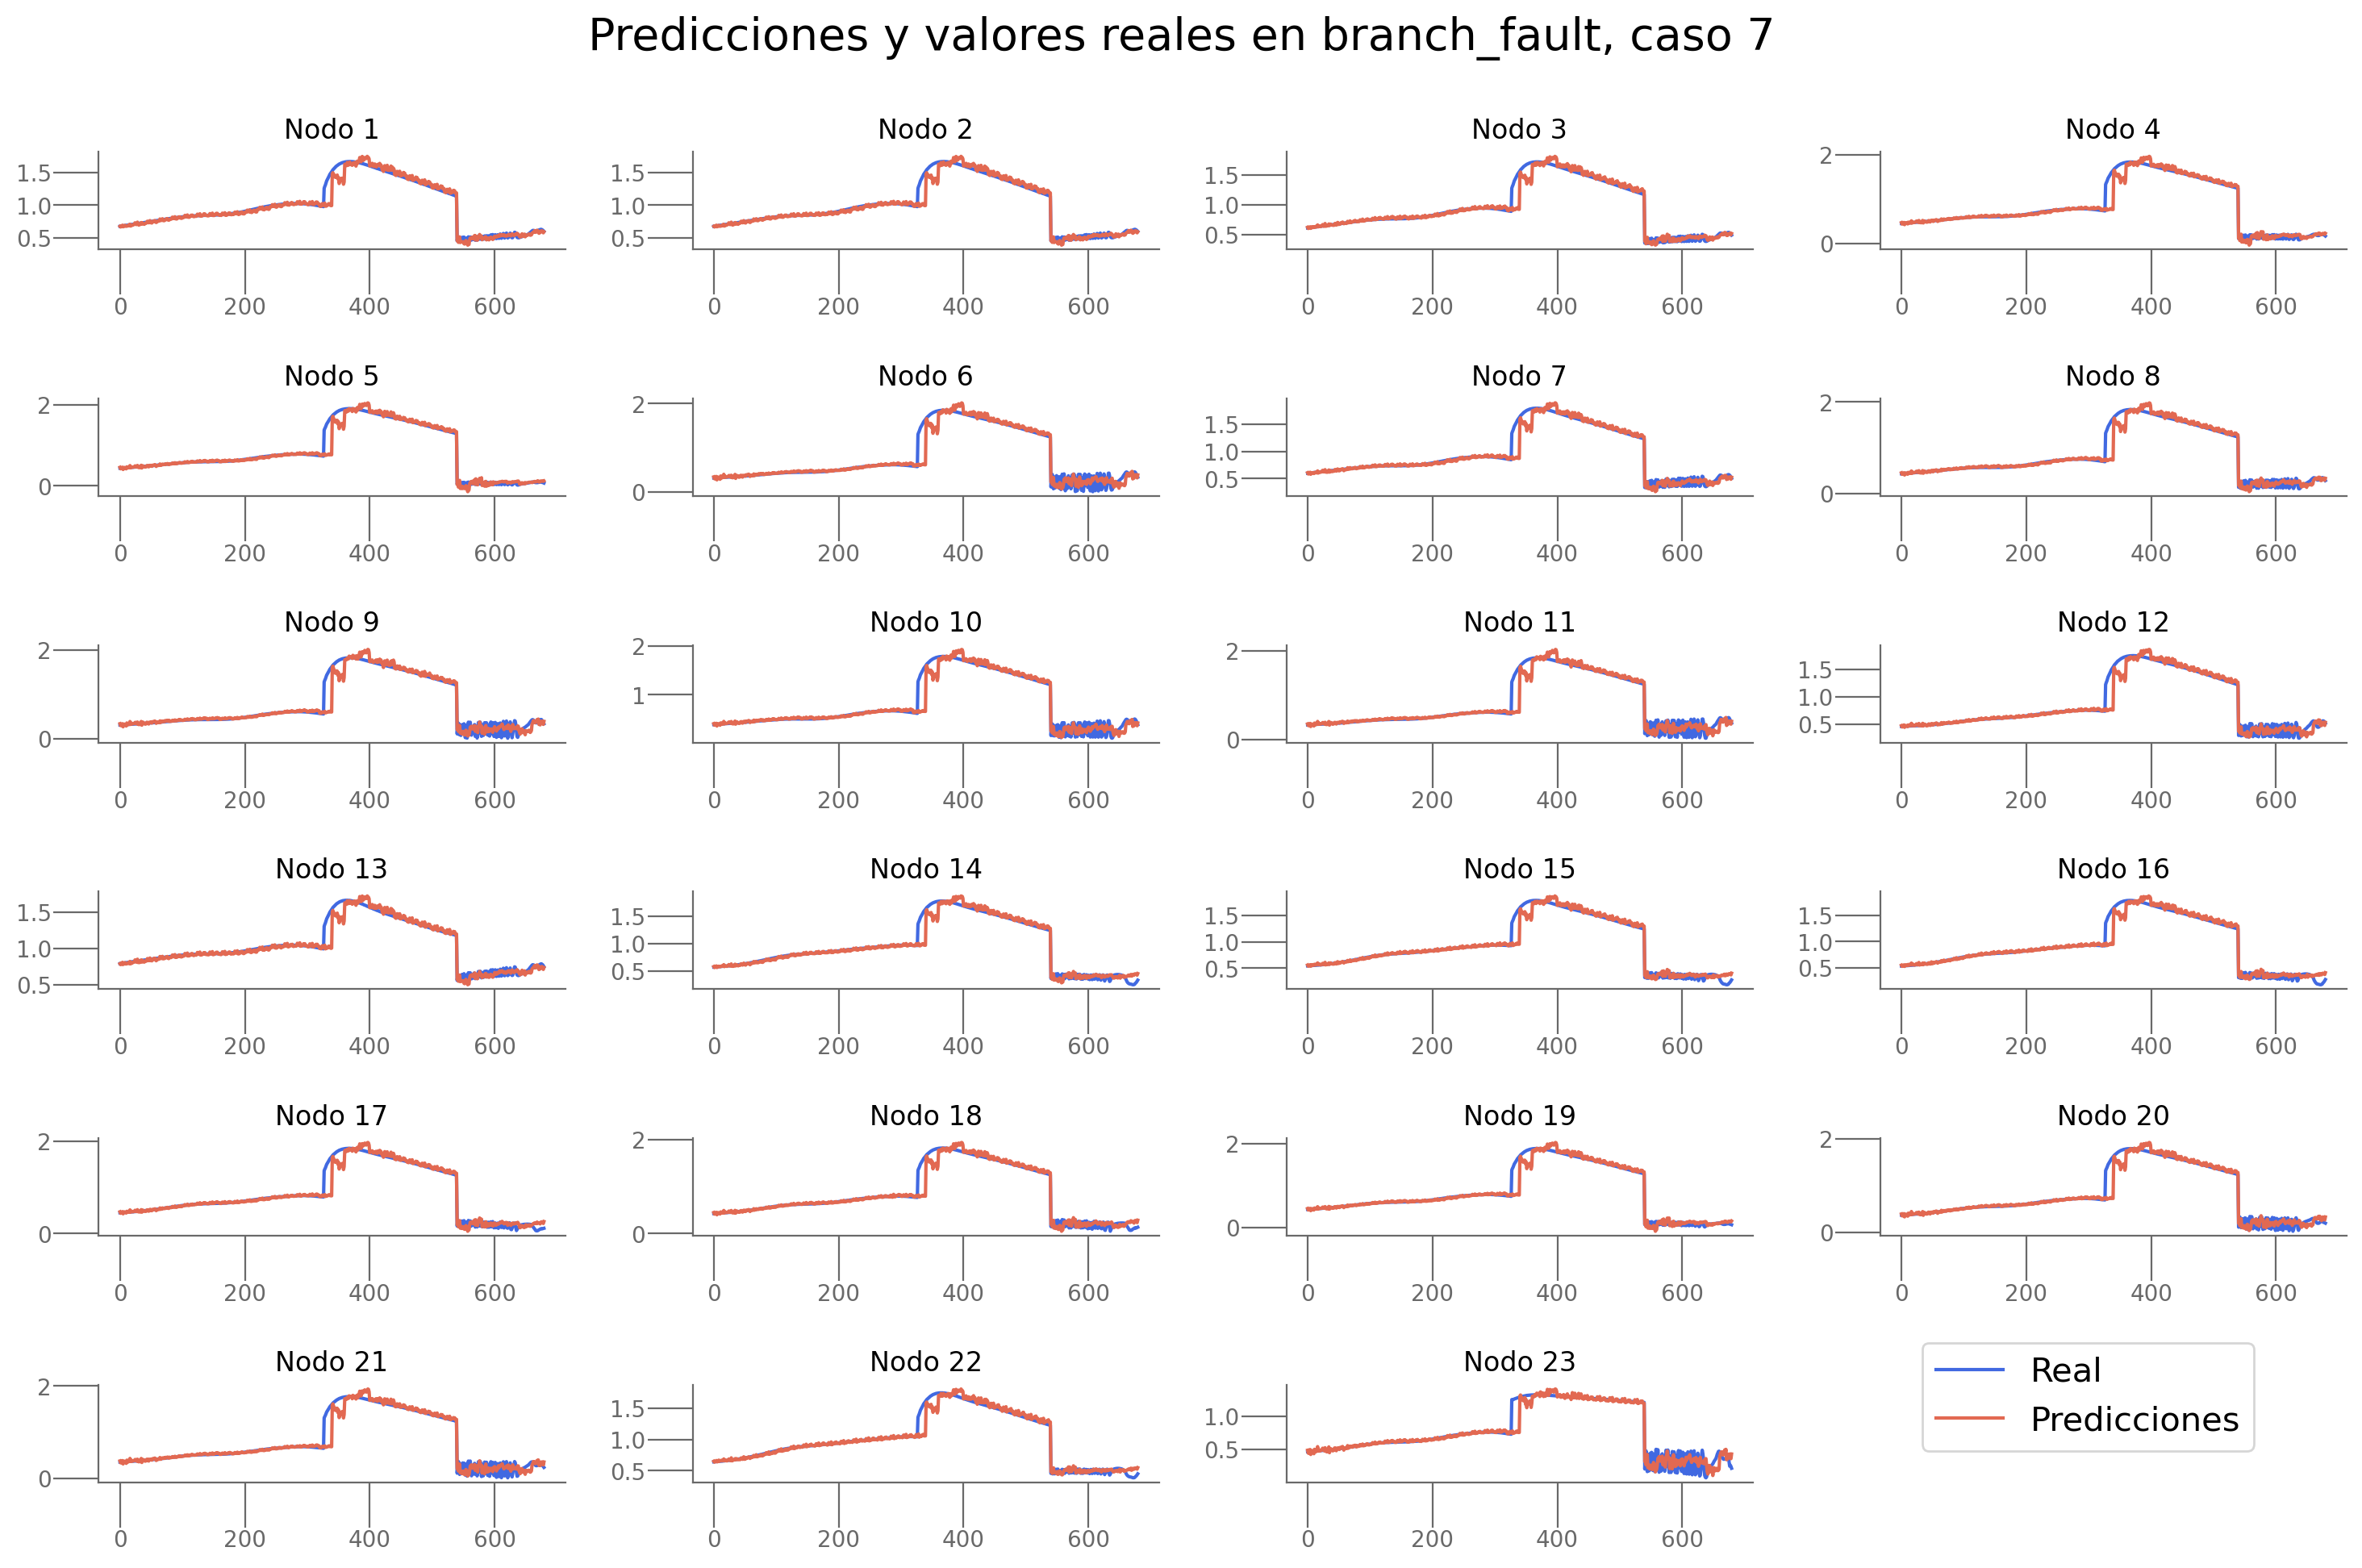

In [ ]:
plot_predictions(predictions_brf, real_brf, n_target, 7, n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [ ]:
param_grid = {
    "out_channels": [16, 32, 64],
    "kernel_size": [3,5,7],
    "normalization": ["sym", "rw"],
    "hidden_channels": [16, 32, 64],
}

trainer_brf,params_brf,resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_mpnn_stconv(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1262 | Eval Loss: 0.0669 | Eval R2: -6.7974 | 
Epoch 2/30 | Train Loss: 0.0449 | Eval Loss: 0.0511 | Eval R2: -5.2292 | 
Epoch 3/30 | Train Loss: 0.0368 | Eval Loss: 0.0436 | Eval R2: -4.5185 | 
Epoch 4/30 | Train Loss: 0.0325 | Eval Loss: 0.0395 | Eval R2: -4.1036 | 
Epoch 5/30 | Train Loss: 0.0300 | Eval Loss: 0.0371 | Eval R2: -3.8579 | 
Epoch 6/30 | Train Loss: 0.0285 | Eval Loss: 0.0356 | Eval R2: -3.6888 | 
Epoch 7/30 | Train Loss: 0.0275 | Eval Loss: 0.0345 | Eval R2: -3.5618 | 
Epoch 8/30 | Train Loss: 0.0267 | Eval Loss: 0.0337 | Eval R2: -3.4758 | 
Epoch 9/30 | Train Loss: 0.0261 | Eval Loss: 0.0331 | Eval R2: -3.4143 | 
Epoch 10/30 | Train Loss: 0.0256 | Eval Loss: 0.0325 | Eval R2: -3.3477 | 
Epoch 11/30 | Train Loss: 0.0251 | Eval Loss: 0.0322 | Eval R2: -3.3122 | 
Epoch 12/30 

 11%|█         | 1/9 [19:06<2:32:54, 1146.82s/it]

preds:  (1, 23, 20)
test loss: 0.021966, test r2score -1.646109
Parámetros:  16 0.2
Resultados:  {'Hidden Size': 16, 'Dropout': 0.2, 'loss_final': 0.021179471164941788, 'r2_eval_final': -3.0248498916625977, 'loss_eval_final': 0.028965508565306664, 'r2_test': -1.6461092947476241, 'loss_test': 0.021966274827718735, 'loss_nodes': [[0.004306233022361994, 0.008762994781136513, 0.011619692668318748, 0.011286788620054722, 0.01340759638696909, 0.013890559785068035, 0.017669854685664177, 0.020324666053056717, 0.025506624951958656, 0.021709289401769638, 0.022796982899308205, 0.026174649596214294, 0.02897927723824978, 0.02906719781458378, 0.029864195734262466, 0.02738748863339424, 0.030587373301386833, 0.030975524336099625, 0.0339154377579689, 0.031093114987015724]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1264 | Eval Loss: 0.0670 | Eval R2

 22%|██▏       | 2/9 [39:37<2:19:32, 1196.13s/it]

preds:  (1, 23, 20)
test loss: 0.022098, test r2score -1.652446
Parámetros:  16 0.5
Resultados:  {'Hidden Size': 16, 'Dropout': 0.5, 'loss_final': 0.021221710368990898, 'r2_eval_final': -3.013749361038208, 'loss_eval_final': 0.02897545136511326, 'r2_test': -1.6524456384209003, 'loss_test': 0.022097861394286156, 'loss_nodes': [[0.0043205698020756245, 0.008761784061789513, 0.011630472727119923, 0.01131234411150217, 0.013564027845859528, 0.01393820345401764, 0.01771819218993187, 0.02035411074757576, 0.02571023814380169, 0.021829256787896156, 0.02286800928413868, 0.026271775364875793, 0.029066845774650574, 0.029268566519021988, 0.03014642931520939, 0.0275418758392334, 0.030781740322709084, 0.031186584383249283, 0.034276533871889114, 0.031409747898578644]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1265 | Eval Loss: 0.0670 | Eval R2: -6

 33%|███▎      | 3/9 [59:49<2:00:20, 1203.49s/it]

preds:  (1, 23, 20)
test loss: 0.022047, test r2score -1.656098
Parámetros:  16 0.8
Resultados:  {'Hidden Size': 16, 'Dropout': 0.8, 'loss_final': 0.021227050572633743, 'r2_eval_final': -3.0222902297973633, 'loss_eval_final': 0.0289751123636961, 'r2_test': -1.6560975907752071, 'loss_test': 0.02204689383506775, 'loss_nodes': [[0.004336196463555098, 0.008732905611395836, 0.011678287759423256, 0.011328457854688168, 0.01345048751682043, 0.013984275981783867, 0.017718179151415825, 0.020330458879470825, 0.02554621547460556, 0.021733105182647705, 0.022792914882302284, 0.026297396048903465, 0.029102884232997894, 0.029185092076659203, 0.030072495341300964, 0.02749030292034149, 0.030655520036816597, 0.031117958948016167, 0.03409574553370476, 0.031289033591747284]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0951 | Eval Loss: 0.0625 | Eval R2:

 44%|████▍     | 4/9 [1:21:41<1:43:52, 1246.40s/it]

preds:  (1, 23, 20)
test loss: 0.021935, test r2score -1.654326
Parámetros:  32 0.2
Resultados:  {'Hidden Size': 32, 'Dropout': 0.2, 'loss_final': 0.02030460722744465, 'r2_eval_final': -2.972918748855591, 'loss_eval_final': 0.028554150834679604, 'r2_test': -1.6543257325692826, 'loss_test': 0.021934838965535164, 'loss_nodes': [[0.005922132171690464, 0.00839442852884531, 0.009059259667992592, 0.014868197962641716, 0.013163075782358646, 0.014968952164053917, 0.017175450921058655, 0.018935509026050568, 0.023432865738868713, 0.021392080932855606, 0.02381976880133152, 0.025656620040535927, 0.0284657534211874, 0.028470078483223915, 0.029049696400761604, 0.02810322493314743, 0.031280867755413055, 0.03081967681646347, 0.03492322936654091, 0.03079591691493988]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0954 | Eval Loss: 0.0626 | Eval R2: -6

 56%|█████▌    | 5/9 [1:43:03<1:23:57, 1259.27s/it]

preds:  (1, 23, 20)
test loss: 0.022113, test r2score -1.670209
Parámetros:  32 0.5
Resultados:  {'Hidden Size': 32, 'Dropout': 0.5, 'loss_final': 0.02079552225768566, 'r2_eval_final': -2.9937493801116943, 'loss_eval_final': 0.02847299911081791, 'r2_test': -1.6702089696854294, 'loss_test': 0.022113006561994553, 'loss_nodes': [[0.005944485776126385, 0.008393709547817707, 0.008974212221801281, 0.014906576834619045, 0.013417169451713562, 0.015128214843571186, 0.017019351944327354, 0.018955348059535027, 0.023695938289165497, 0.021407151594758034, 0.024078598245978355, 0.02564067952334881, 0.028391927480697632, 0.02892458252608776, 0.02950487844645977, 0.02867267094552517, 0.03182632476091385, 0.03097299113869667, 0.03525976091623306, 0.031145604327321053]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0959 | Eval Loss: 0.0630 | Eval R2: -

 67%|██████▋   | 6/9 [2:08:24<1:07:24, 1348.04s/it]

preds:  (1, 23, 20)
test loss: 0.021976, test r2score -1.673605
Parámetros:  32 0.8
Resultados:  {'Hidden Size': 32, 'Dropout': 0.8, 'loss_final': 0.020823895931243896, 'r2_eval_final': -3.0159127712249756, 'loss_eval_final': 0.02844853699207306, 'r2_test': -1.673605186583728, 'loss_test': 0.021975567564368248, 'loss_nodes': [[0.00593263003975153, 0.008373623713850975, 0.008971959352493286, 0.014815309084951878, 0.013252290897071362, 0.015190571546554565, 0.017004618421196938, 0.01892152801156044, 0.023277105763554573, 0.021388493478298187, 0.023975543677806854, 0.025529984384775162, 0.028441226109862328, 0.02860565111041069, 0.02913658507168293, 0.028331028297543526, 0.031484171748161316, 0.030938688665628433, 0.03496026620268822, 0.030980071052908897]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0963 | Eval Loss: 0.0637 | Eval R2:

 78%|███████▊  | 7/9 [2:34:15<47:08, 1414.48s/it]  

preds:  (1, 23, 20)
test loss: 0.021592, test r2score -1.565135
Parámetros:  64 0.2
Resultados:  {'Hidden Size': 64, 'Dropout': 0.2, 'loss_final': 0.020219268277287483, 'r2_eval_final': -2.8992807865142822, 'loss_eval_final': 0.028203312307596207, 'r2_test': -1.5651352385914707, 'loss_test': 0.021591849625110626, 'loss_nodes': [[0.004606356844305992, 0.008385415188968182, 0.009615015238523483, 0.011347350664436817, 0.013450238853693008, 0.014165022410452366, 0.017569683492183685, 0.01885198801755905, 0.02388034015893936, 0.022325431928038597, 0.02287341095507145, 0.024491937831044197, 0.028251005336642265, 0.028822867199778557, 0.0299274530261755, 0.027653811499476433, 0.030463002622127533, 0.031088341027498245, 0.033868104219436646, 0.030200187116861343]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0967 | Eval Loss: 0.0643 | Eval R

 89%|████████▉ | 8/9 [2:55:42<22:53, 1373.72s/it]

preds:  (1, 23, 20)
test loss: 0.021681, test r2score -1.601664
Parámetros:  64 0.5
Resultados:  {'Hidden Size': 64, 'Dropout': 0.5, 'loss_final': 0.020462216809391975, 'r2_eval_final': -2.941521167755127, 'loss_eval_final': 0.02849261462688446, 'r2_test': -1.6016640679929695, 'loss_test': 0.021681470796465874, 'loss_nodes': [[0.00458146259188652, 0.008374982513487339, 0.009567790664732456, 0.011236914433538914, 0.013496467843651772, 0.014265499077737331, 0.017594847828149796, 0.018983233720064163, 0.023706786334514618, 0.022294597700238228, 0.02292667143046856, 0.024655070155858994, 0.028522979468107224, 0.029033763334155083, 0.030147377401590347, 0.027732396498322487, 0.03073139302432537, 0.03142639249563217, 0.03410952165722847, 0.030241286382079124]]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0970 | Eval Loss: 0.0662 | Eval R2:

100%|██████████| 9/9 [3:19:38<00:00, 1330.92s/it]

preds:  (1, 23, 20)
test loss: 0.021935, test r2score -1.630222
Parámetros:  64 0.8
Resultados:  {'Hidden Size': 64, 'Dropout': 0.8, 'loss_final': 0.020738698542118073, 'r2_eval_final': -2.9701738357543945, 'loss_eval_final': 0.028473056852817535, 'r2_test': -1.6302219738910282, 'loss_test': 0.0219354797154665, 'loss_nodes': [[0.0045873322524130344, 0.008348768576979637, 0.009609286673367023, 0.011244641616940498, 0.01372663863003254, 0.014326198026537895, 0.017707062885165215, 0.01917736418545246, 0.02430136688053608, 0.022692721337080002, 0.02343132719397545, 0.024938402697443962, 0.028934136033058167, 0.029333986341953278, 0.03065614216029644, 0.028037482872605324, 0.030957218259572983, 0.03161216527223587, 0.03455531597137451, 0.03053199127316475]]}


In [ ]:
_, _, _, predictions_brf_ajuste, real_brf_ajuste = trainer_brf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.021592, test r2score -1.565135


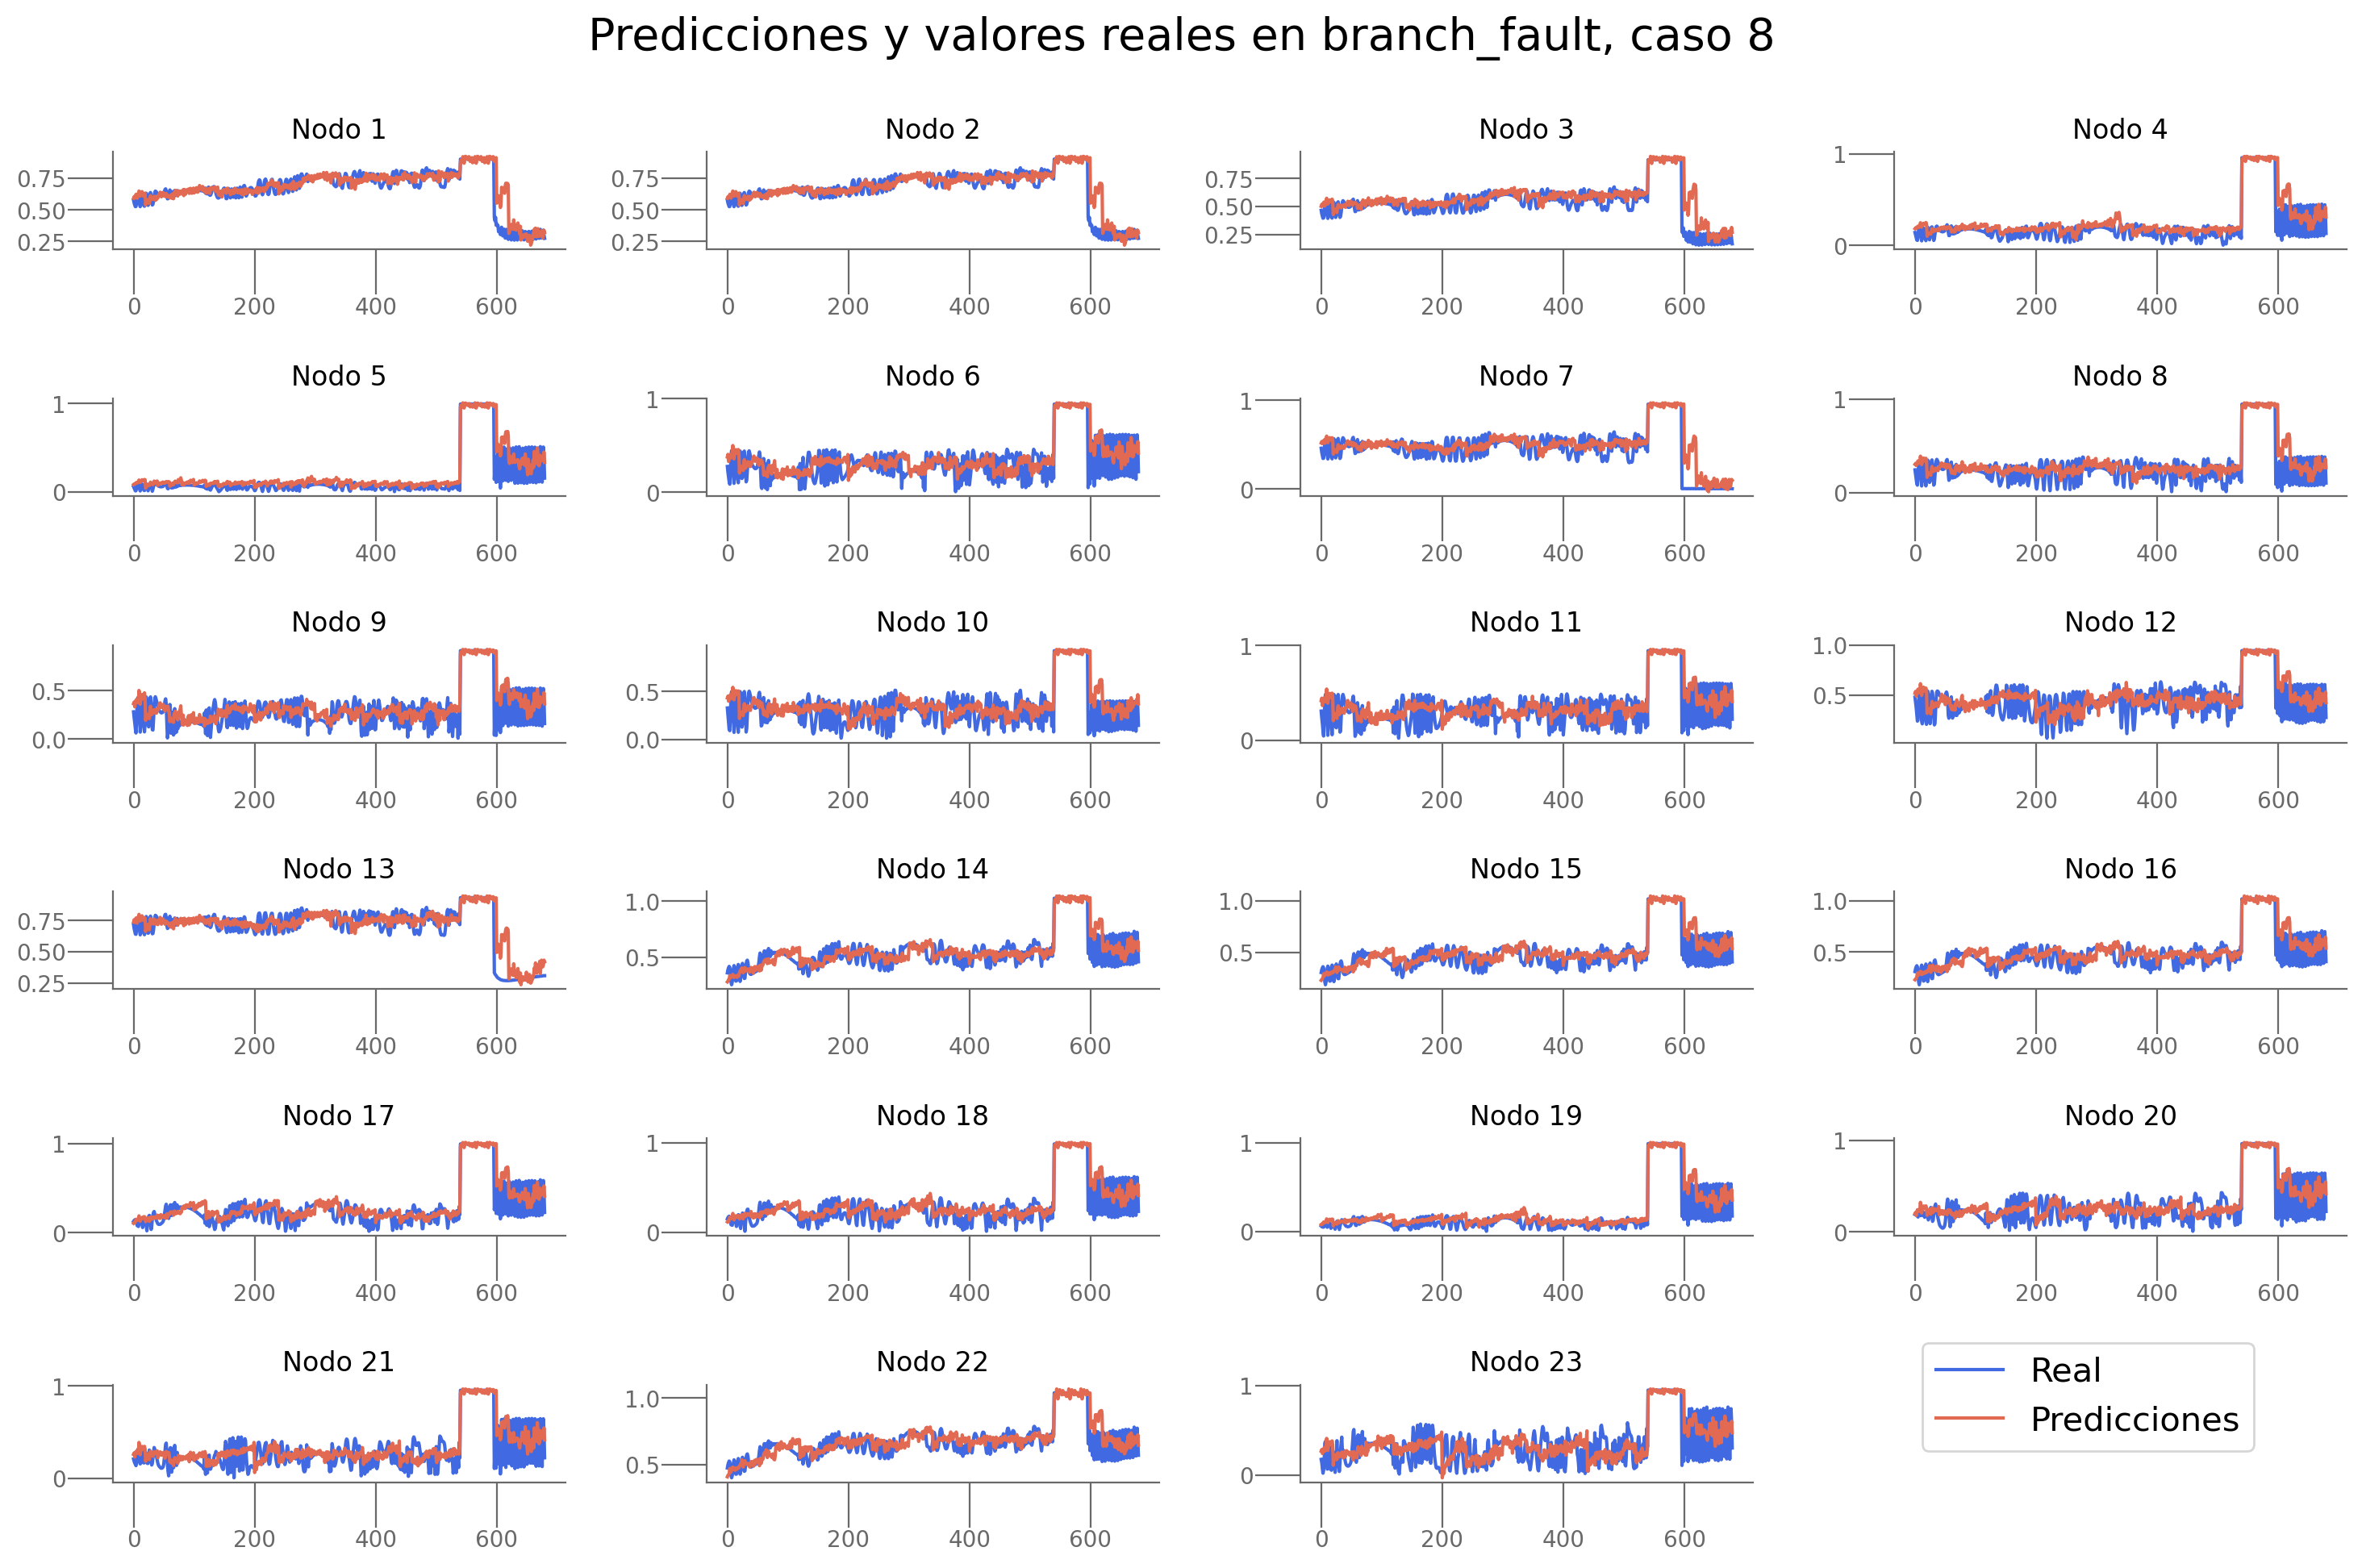

In [ ]:
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 8, n_div_brf, problem_brf)

In [ ]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)

In [ ]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params=params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM    {'hidden_size': 64, 'dropout': 0.2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.565135   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01155095 0.00907443 0.01350776 0.02466182 0...  0.584785   0.029613   
1  [0.01080354 0.00768281 0.0111787  0.02304618 0... -2.690716   0.028298   
2  [[0.00480468 0.008134   0.0154

### Branch trip

In [ ]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [ ]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [ ]:

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model_brt = RecurrentGCN(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=30,k=2, kernel_size=5, hidden_channels=16, normalization="sym")

trainer_brt = TrainerSTConv(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1194 | Eval Loss: 0.0346 | Eval R2: -19.7835 | 
Epoch 2/30 | Train Loss: 0.0217 | Eval Loss: 0.0246 | Eval R2: -13.3083 | 
Epoch 3/30 | Train Loss: 0.0173 | Eval Loss: 0.0200 | Eval R2: -10.7555 | 
Epoch 4/30 | Train Loss: 0.0142 | Eval Loss: 0.0164 | Eval R2: -8.7512 | 
Epoch 5/30 | Train Loss: 0.0119 | Eval Loss: 0.0136 | Eval R2: -7.1837 | 
Epoch 6/30 | Train Loss: 0.0103 | Eval Loss: 0.0113 | Eval R2: -5.8904 | 
Epoch 7/30 | Train Loss: 0.0089 | Eval Loss: 0.0097 | Eval R2: -4.8930 | 
Epoch 8/30 | Train Loss: 0.0078 | Eval Loss: 0.0083 | Eval R2: -4.0556 | 
Epoch 9/30 | Train Loss: 0.0070 | Eval Loss: 0.0073 | Eval R2: -3.4072 | 
Epoch 10/30 | Train Loss: 0.0064 | Eval Loss: 0.0065 | Eval R2: -2.9433 | 
Epoch 11/30 | Train Loss: 0.0059 | Eval Loss: 0.0060 | Eval R2: -2.6181 | 
Epoch 12/

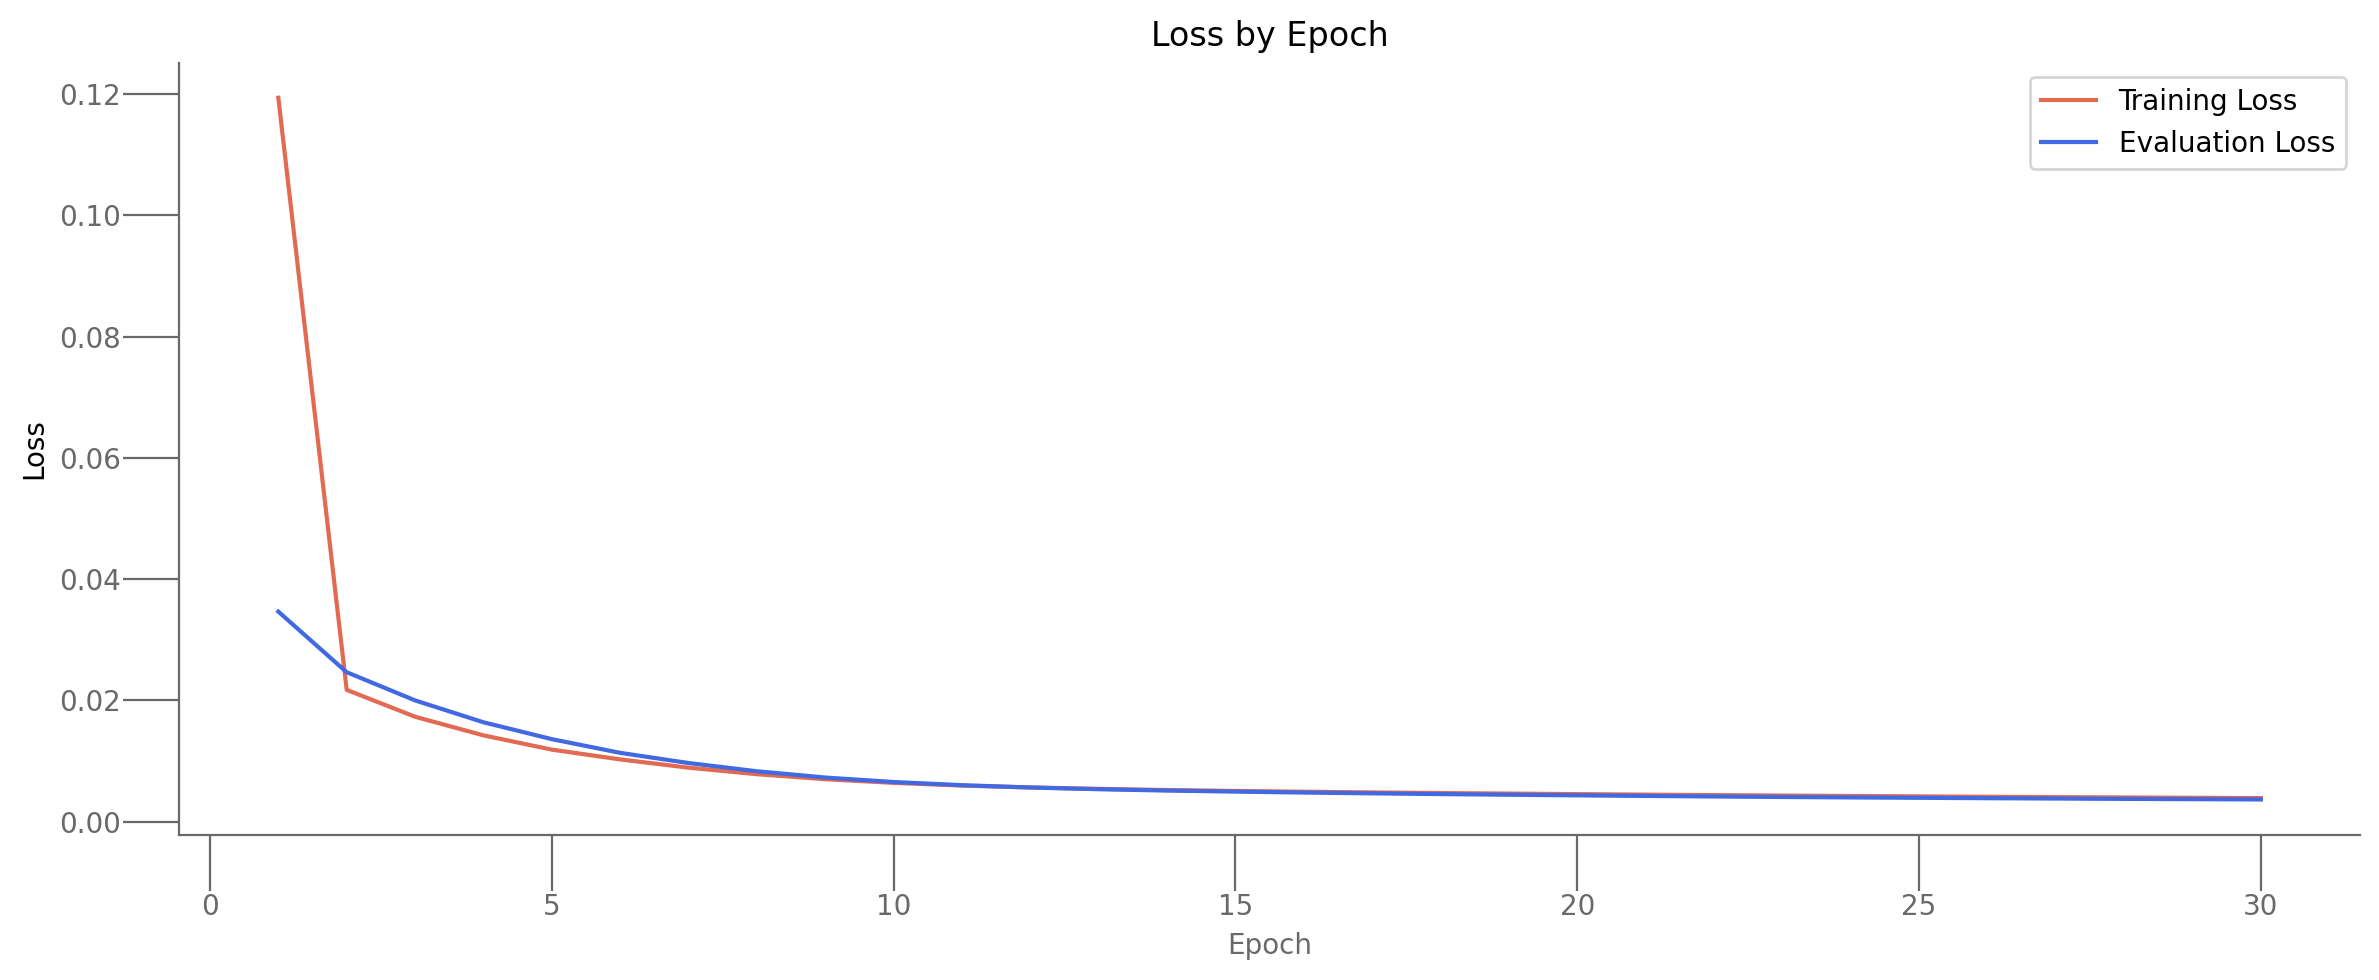


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004208, test r2score -1.445138


In [ ]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()

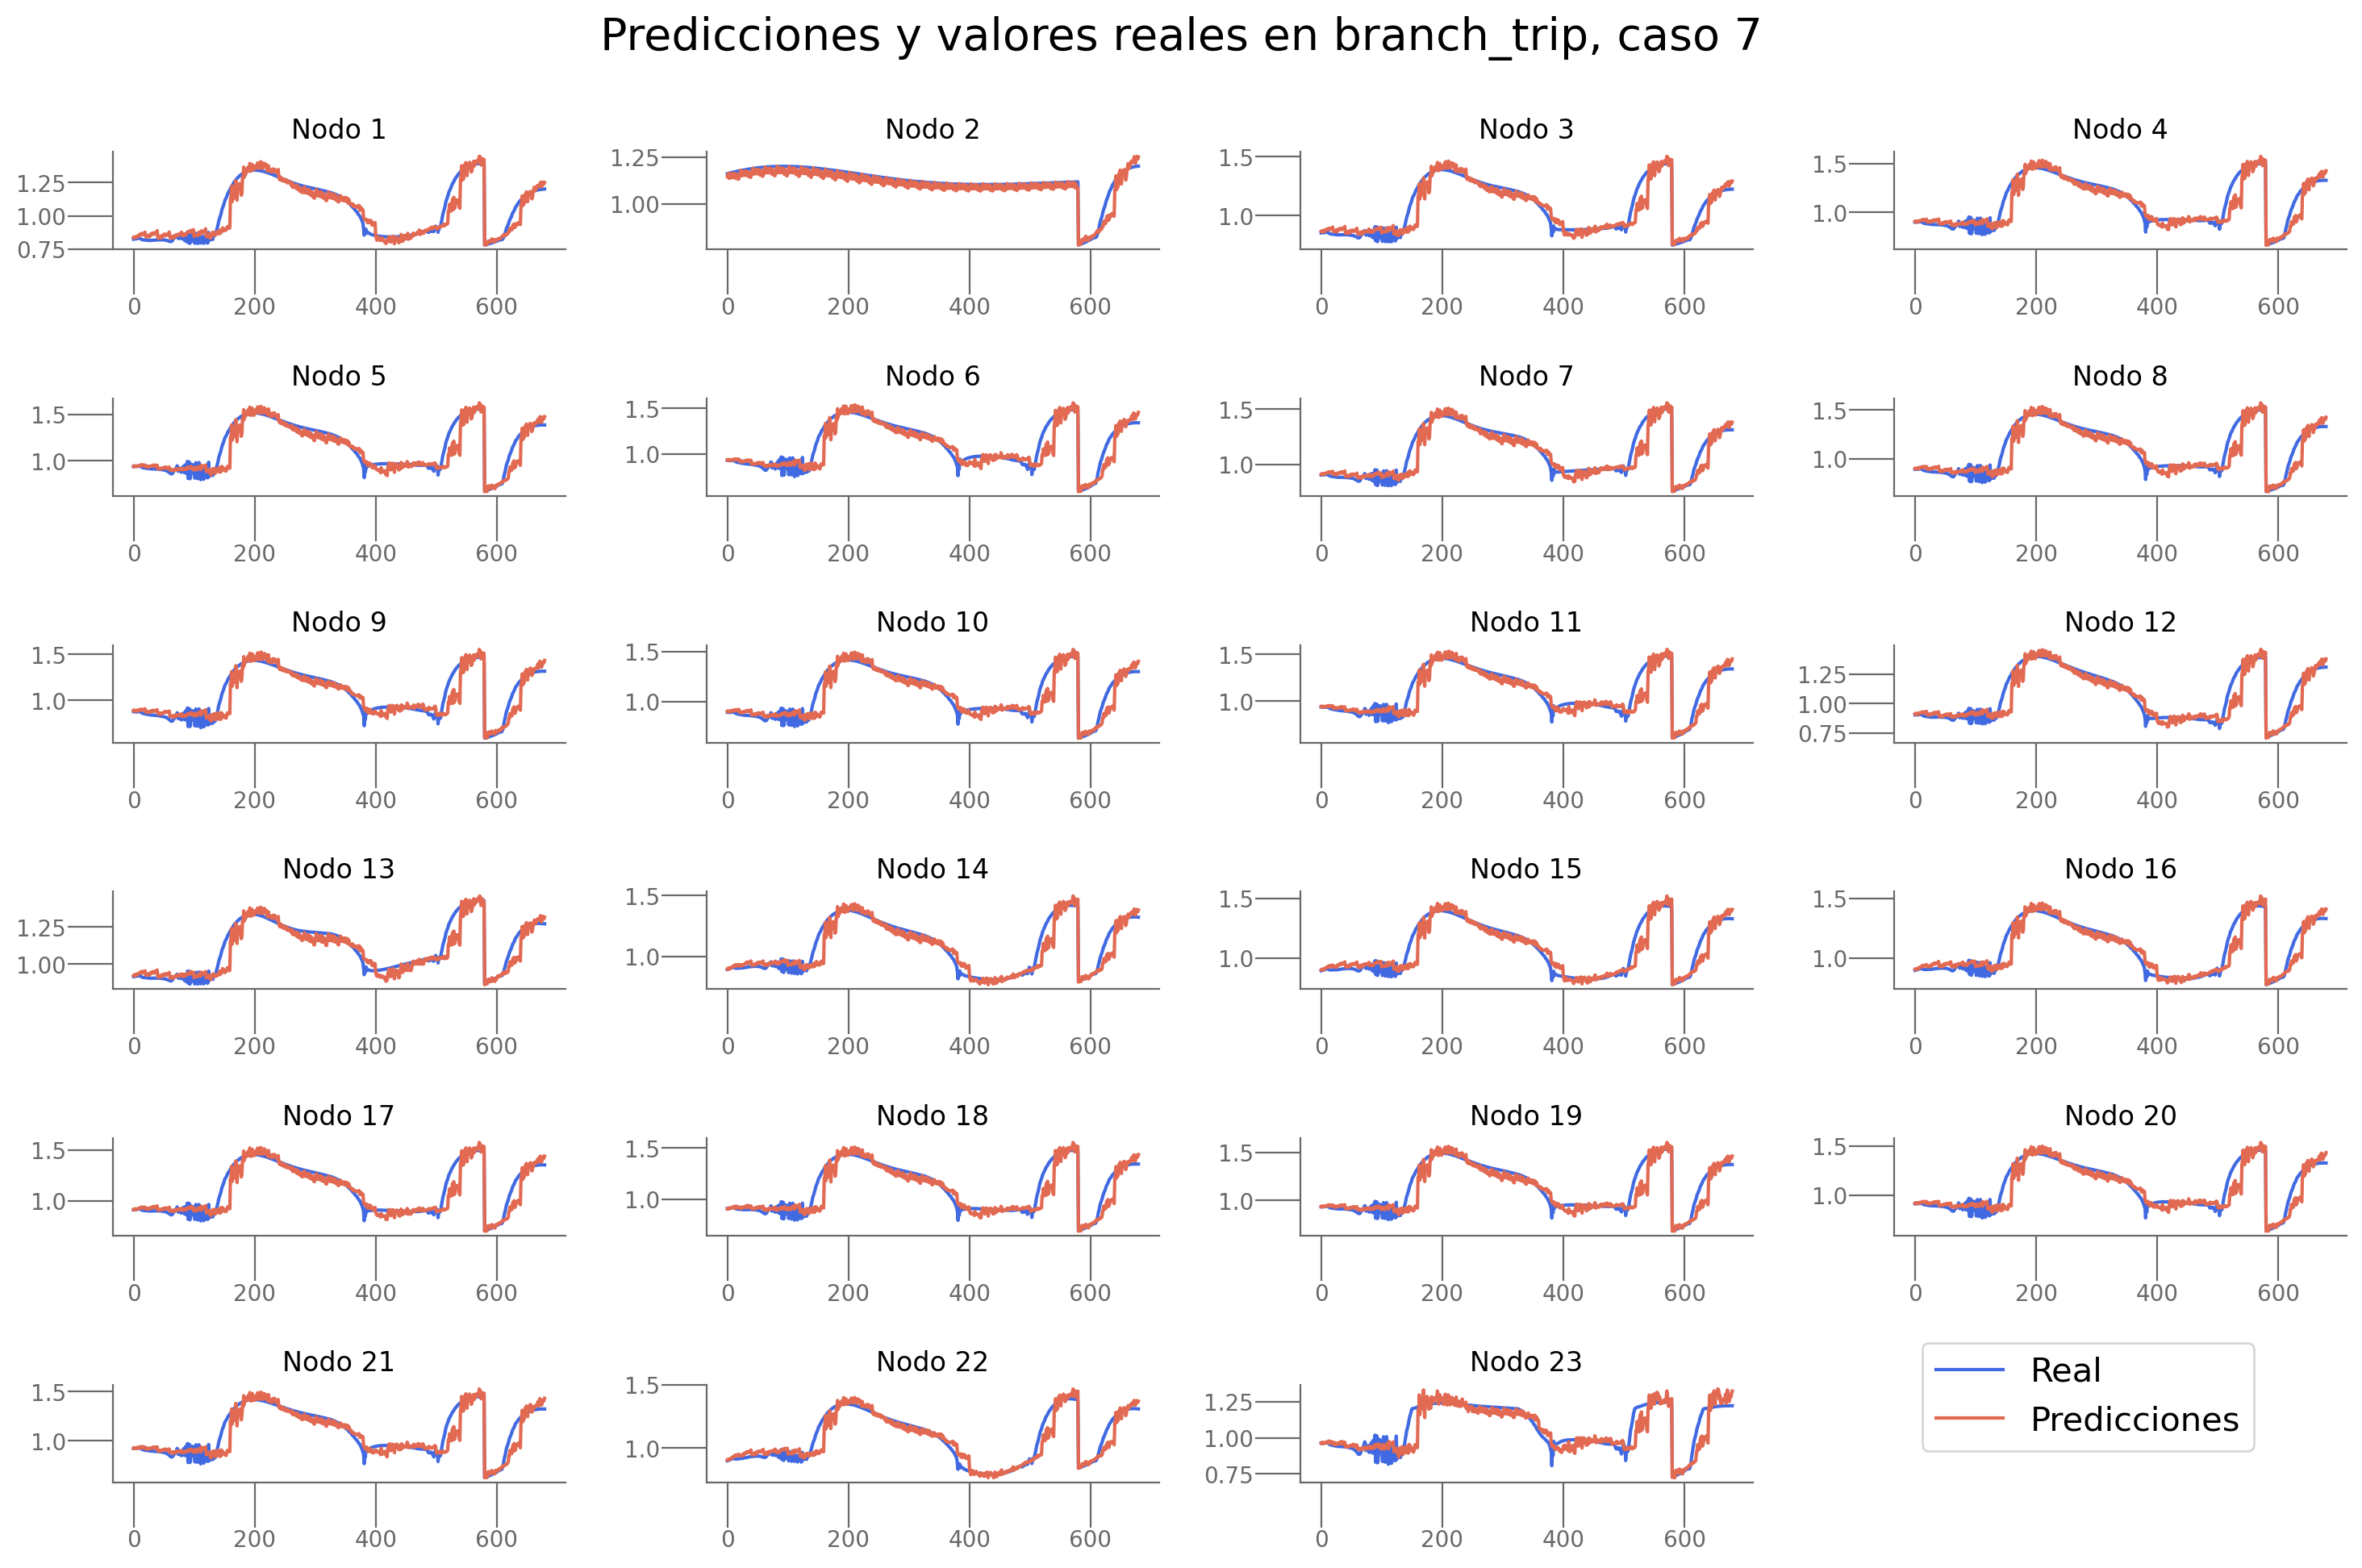

In [ ]:
plot_predictions(predictions_brt, real_brt, n_target, 7, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [ ]:
param_grid = {
    "out_channels": [16, 32, 64],
    "kernel_size": [3,5,7],
    "normalization": ["sym", "rw"],
    "hidden_channels": [16, 32, 64],
}

trainer_brt,params_brt,resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_stconv(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1817 | Eval Loss: 0.0353 | Eval R2: -20.0603 | 
Epoch 2/30 | Train Loss: 0.0234 | Eval Loss: 0.0271 | Eval R2: -14.7822 | 
Epoch 3/30 | Train Loss: 0.0194 | Eval Loss: 0.0229 | Eval R2: -12.4292 | 
Epoch 4/30 | Train Loss: 0.0165 | Eval Loss: 0.0190 | Eval R2: -10.3006 | 
Epoch 5/30 | Train Loss: 0.0141 | Eval Loss: 0.0159 | Eval R2: -8.5660 | 
Epoch 6/30 | Train Loss: 0.0121 | Eval Loss: 0.0142 | Eval R2: -7.5843 | 
Epoch 7/30 | Train Loss: 0.0105 | Eval Loss: 0.0121 | Eval R2: -6.4147 | 
Epoch 8/30 | Train Loss: 0.0092 | Eval Loss: 0.0101 | Eval R2: -5.3470 | 
Epoch 9/30 | Train Loss: 0.0085 | Eval Loss: 0.0090 | Eval R2: -4.6590 | 
Epoch 10/30 | Train Loss: 0.0074 | Eval Loss: 0.0087 | Eval R2: -4.4483 | 
Epoch 11/30 | Train Loss: 0.0069 | Eval Loss: 0.0077 | Eval R2: -3.7977 | 
Epoch 12

 11%|█         | 1/9 [21:34<2:52:37, 1294.71s/it]

preds:  (1, 23, 20)
test loss: 0.004754, test r2score -1.731968
Parámetros:  16 0.2
Resultados:  {'Hidden Size': 16, 'Dropout': 0.2, 'loss_final': 0.004217044450342655, 'r2_eval_final': -1.459521770477295, 'loss_eval_final': 0.004083360079675913, 'r2_test': -1.731967638227696, 'loss_test': 0.00475397938862443, 'loss_nodes': [[0.0010456854943186045, 0.0015521199675276875, 0.002577408216893673, 0.0015234950697049499, 0.0025341103319078684, 0.001464538392610848, 0.003220214042812586, 0.004792336840182543, 0.003834282048046589, 0.004306911490857601, 0.004673491232097149, 0.005083987955003977, 0.004571740981191397, 0.005799226928502321, 0.006120365113019943, 0.007289999630302191, 0.009009337984025478, 0.00706308800727129, 0.008929640054702759, 0.009687600657343864]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1819 | Eval Loss: 0.0354 | E

 22%|██▏       | 2/9 [45:03<2:38:53, 1361.89s/it]

preds:  (1, 23, 20)
test loss: 0.004715, test r2score -1.705752
Parámetros:  16 0.5
Resultados:  {'Hidden Size': 16, 'Dropout': 0.5, 'loss_final': 0.004190646577626467, 'r2_eval_final': -1.4370789527893066, 'loss_eval_final': 0.004052705597132444, 'r2_test': -1.7057520881719215, 'loss_test': 0.004715447314083576, 'loss_nodes': [[0.001034405897371471, 0.0015231779543682933, 0.002547136740759015, 0.0015134522691369057, 0.002514390042051673, 0.001454669050872326, 0.003197017125785351, 0.0047414363361895084, 0.0037761665880680084, 0.004245399497449398, 0.004639501683413982, 0.005039237439632416, 0.004563300404697657, 0.005751277320086956, 0.0061286878772079945, 0.0072506507858633995, 0.008914275094866753, 0.007038229610770941, 0.008861204609274864, 0.00957534834742546]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1820 | Eval Loss: 0.035

 33%|███▎      | 3/9 [1:05:31<2:10:03, 1300.60s/it]

preds:  (1, 23, 20)
test loss: 0.004722, test r2score -1.711765
Parámetros:  16 0.8
Resultados:  {'Hidden Size': 16, 'Dropout': 0.8, 'loss_final': 0.004195153713226318, 'r2_eval_final': -1.441754937171936, 'loss_eval_final': 0.004055287688970566, 'r2_test': -1.7117649782075846, 'loss_test': 0.0047220210544764996, 'loss_nodes': [[0.0010312728118151426, 0.001533708069473505, 0.0025429450906813145, 0.0015007929177954793, 0.002515708329156041, 0.0014577592955902219, 0.0032189618796110153, 0.004753604996949434, 0.003779405727982521, 0.0042635067366063595, 0.004659560509026051, 0.005046824458986521, 0.004574615973979235, 0.005771734286099672, 0.00607397872954607, 0.007263056002557278, 0.008971884846687317, 0.007032012566924095, 0.008857863955199718, 0.009591236710548401]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1190 | Eval Loss: 0.034

 44%|████▍     | 4/9 [1:23:54<1:41:53, 1222.79s/it]

preds:  (1, 23, 20)
test loss: 0.004239, test r2score -1.488445
Parámetros:  32 0.2
Resultados:  {'Hidden Size': 32, 'Dropout': 0.2, 'loss_final': 0.003876025089994073, 'r2_eval_final': -1.2020256519317627, 'loss_eval_final': 0.0036717478651553392, 'r2_test': -1.4884447430026353, 'loss_test': 0.0042388178408145905, 'loss_nodes': [[0.0017460128292441368, 0.0019829561933875084, 0.0013829419622197747, 0.002532996004447341, 0.001938186353072524, 0.003169676521793008, 0.002214261796325445, 0.0021805253345519304, 0.003868485102429986, 0.002411911729723215, 0.004574952181428671, 0.005473218392580748, 0.005004614591598511, 0.004883459769189358, 0.005379104521125555, 0.0053166733123362064, 0.006615067832171917, 0.006535166408866644, 0.00831541232764721, 0.009250746108591557]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1194 | Eval Loss: 0.03

 56%|█████▌    | 5/9 [1:42:39<1:19:10, 1187.56s/it]

preds:  (1, 23, 20)
test loss: 0.004209, test r2score -1.455081
Parámetros:  32 0.5
Resultados:  {'Hidden Size': 32, 'Dropout': 0.5, 'loss_final': 0.0038669316563755274, 'r2_eval_final': -1.1937737464904785, 'loss_eval_final': 0.003633905900642276, 'r2_test': -1.4550814952581543, 'loss_test': 0.004208940546959639, 'loss_nodes': [[0.0017280502943322062, 0.001951984828338027, 0.00136514229234308, 0.0025136256590485573, 0.0019267030293121934, 0.003157413098961115, 0.0022161994129419327, 0.00216408702544868, 0.0038172397762537003, 0.0023538002278655767, 0.0045549203641712666, 0.005455812439322472, 0.004946486093103886, 0.00478062080219388, 0.005383494775742292, 0.005284721497446299, 0.006598906125873327, 0.00652121938765049, 0.008270391263067722, 0.009188000112771988]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1200 | Eval Loss: 0.0349

 67%|██████▋   | 6/9 [2:00:56<57:50, 1156.70s/it]  

preds:  (1, 23, 20)
test loss: 0.004205, test r2score -1.453302
Parámetros:  32 0.8
Resultados:  {'Hidden Size': 32, 'Dropout': 0.8, 'loss_final': 0.0038654759991914034, 'r2_eval_final': -1.1953718662261963, 'loss_eval_final': 0.003632256528362632, 'r2_test': -1.45330156295956, 'loss_test': 0.004204955883324146, 'loss_nodes': [[0.0017282096669077873, 0.0019592642784118652, 0.0013782205060124397, 0.002496645785868168, 0.0019269357435405254, 0.003144314745441079, 0.00220175227150321, 0.002154134912416339, 0.00381785212084651, 0.00232850294560194, 0.004543971735984087, 0.005457967985421419, 0.004958296660333872, 0.004764004144817591, 0.005345864221453667, 0.005277271382510662, 0.006593107711523771, 0.0065415180288255215, 0.008289378136396408, 0.009191903285682201]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1239 | Eval Loss: 0.0323 | 

 78%|███████▊  | 7/9 [2:19:37<38:09, 1144.92s/it]

preds:  (1, 23, 20)
test loss: 0.004510, test r2score -1.609638
Parámetros:  64 0.2
Resultados:  {'Hidden Size': 64, 'Dropout': 0.2, 'loss_final': 0.0040392763912677765, 'r2_eval_final': -1.3523730039596558, 'loss_eval_final': 0.00390918692573905, 'r2_test': -1.6096379857021283, 'loss_test': 0.00451008602976799, 'loss_nodes': [[0.0011485583381727338, 0.0012062021996825933, 0.0029101092368364334, 0.002189774066209793, 0.0023524006828665733, 0.002013979945331812, 0.002462579170241952, 0.002561948262155056, 0.003427161369472742, 0.004199047572910786, 0.005742103327065706, 0.004777087364345789, 0.005198182538151741, 0.005548490677028894, 0.006144807208329439, 0.00731539586558938, 0.008654884994029999, 0.007263283245265484, 0.0068769981153309345, 0.00820873212069273]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1245 | Eval Loss: 0.0335 |

 89%|████████▉ | 8/9 [2:40:32<19:40, 1180.03s/it]

preds:  (1, 23, 20)
test loss: 0.004476, test r2score -1.575109
Parámetros:  64 0.5
Resultados:  {'Hidden Size': 64, 'Dropout': 0.5, 'loss_final': 0.004028710536658764, 'r2_eval_final': -1.3239980936050415, 'loss_eval_final': 0.003881248878315091, 'r2_test': -1.5751092622202685, 'loss_test': 0.004475513007491827, 'loss_nodes': [[0.001124858041293919, 0.0012095420388504863, 0.002854094607755542, 0.0021732975728809834, 0.002260626759380102, 0.002017119200900197, 0.0024804018903523684, 0.00257659493945539, 0.0033937119878828526, 0.004119661636650562, 0.00565820187330246, 0.004760561510920525, 0.005123869050294161, 0.005566602107137442, 0.0061399973928928375, 0.007263447158038616, 0.008602779358625412, 0.0071987584233284, 0.006810091435909271, 0.008176046423614025]]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1245 | Eval Loss: 0.0347 | 

100%|██████████| 9/9 [3:06:55<00:00, 1246.15s/it]

preds:  (1, 23, 20)
test loss: 0.004477, test r2score -1.584044
Parámetros:  64 0.8
Resultados:  {'Hidden Size': 64, 'Dropout': 0.8, 'loss_final': 0.00403003953397274, 'r2_eval_final': -1.3265782594680786, 'loss_eval_final': 0.0038852859288454056, 'r2_test': -1.5840436806195306, 'loss_test': 0.00447702594101429, 'loss_nodes': [[0.0011395247420296073, 0.0011804013047367334, 0.002874941099435091, 0.0021589973475784063, 0.00236699590459466, 0.0020133291836827993, 0.002464300487190485, 0.002550265518948436, 0.0034291513729840517, 0.00416739284992218, 0.005673946347087622, 0.004810098558664322, 0.005150339100509882, 0.005504652392119169, 0.006100621540099382, 0.007274108938872814, 0.008577324450016022, 0.007202277425676584, 0.006776833441108465, 0.008125029504299164]]}


In [ ]:
_, _, _, predictions_brt_ajuste, real_brt_ajuste = trainer_brt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004205, test r2score -1.453302


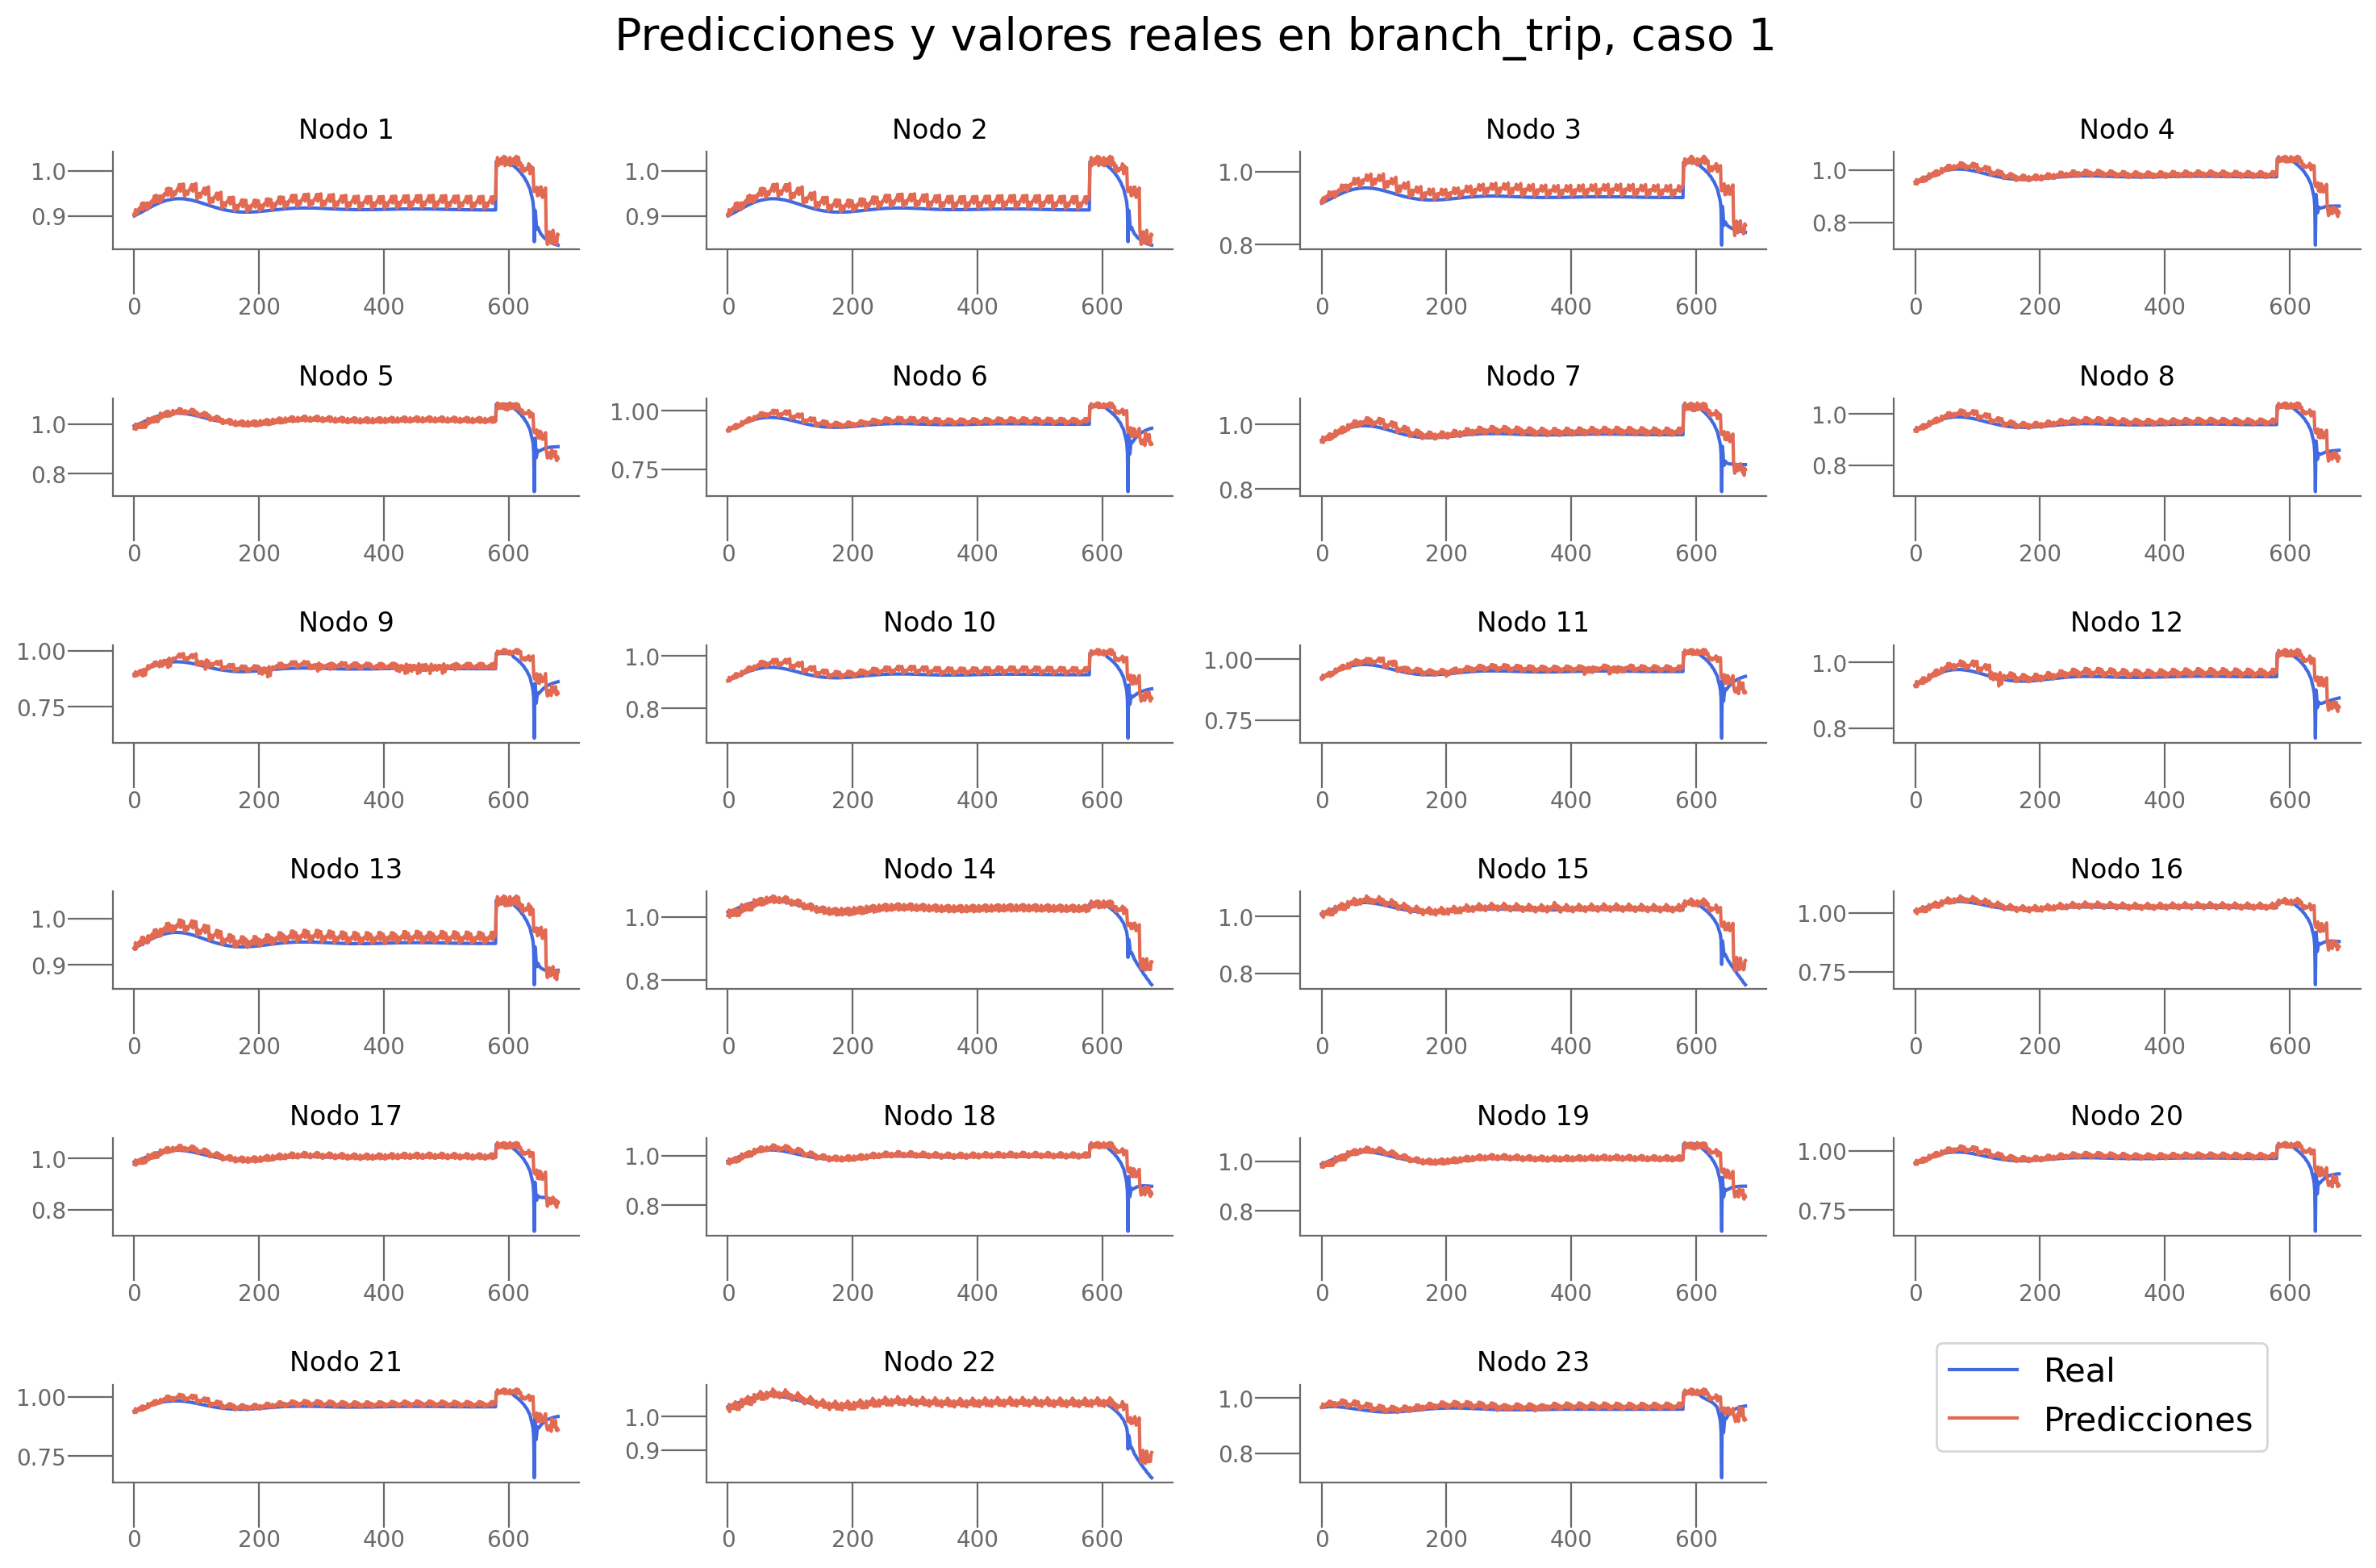

In [ ]:
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [ ]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)

In [ ]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params=params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM    {'hidden_size': 32, 'dropout': 0.8}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3  ./results/branch_trip/ajustes/MPNNLSTM_results...  0.004205 -1.453302   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0036937  0.00202668 0.00244704 0.00374463 0...  0.435549   0.003684   
1  [0.01389701 0.00177465 0.00324512 0.0049619  0... -1.577386   0.004085   
2  [[0.00075153 0.00100153 0.0011